https://github.com/loiccoyle/RPCA

Running RPCA to clean the data (using provided GitHub code)...
RPCA finished. L_matrix (cleaned data) shape: (200, 10)

Running Sparse PCA on the cleaned data (L_matrix)...
Sparse PCA on L_matrix finished.


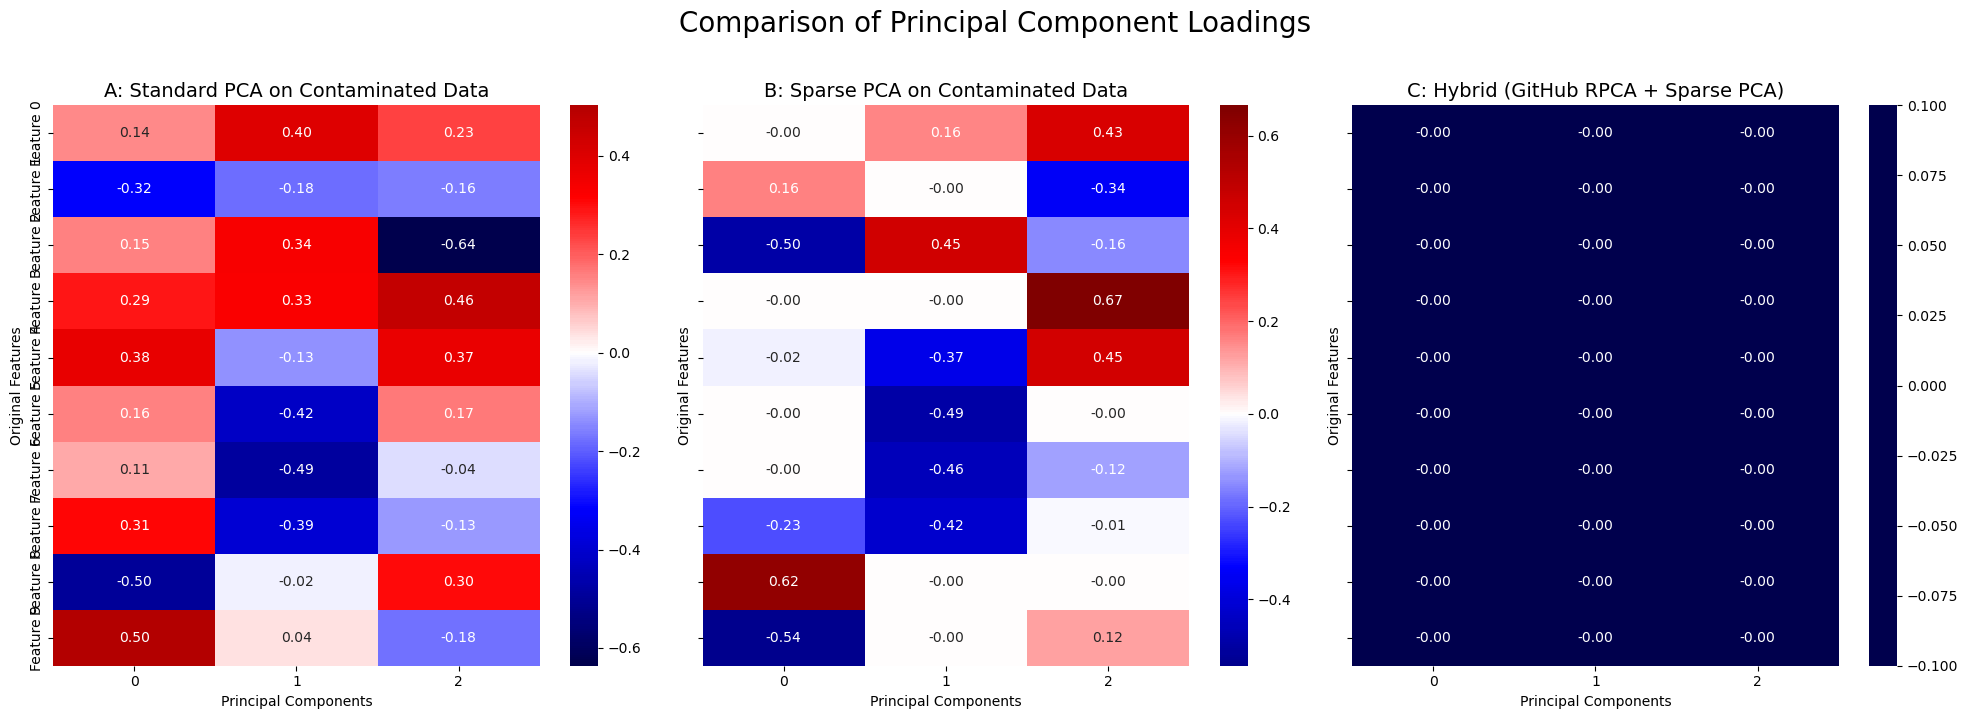

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import svds

# ==============================================================================
# GitHub: loiccoyle/RPCA/rpca/rpca.py 의 핵심 코드
# 출처: https://github.com/loiccoyle/RPCA/blob/main/rpca/rpca.py
# ------------------------------------------------------------------------------
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M
        self.S = np.zeros(self.M.shape)
        self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda

    @staticmethod
    def _shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def fit(self, max_iter=1000, tol=1e-7):
        i = 0
        err = np.inf
        Y = self.M
        
        while err > tol and i < max_iter:
            # S 업데이트: Soft-thresholding 적용
            self.S = self._shrink(Y, self.lmbda)
            
            # L 업데이트: SVD를 이용한 low-rank 근사
            U, s, Vt = svds(self.M - self.S, k=min(self.M.shape)-1)
            self.L = U @ np.diag(s) @ Vt

            # Y(Lagrange Multiplier) 업데이트
            Y = Y + self.M - self.L - self.S

            # 에러 계산
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
            i += 1
            if i % 100 == 0: # 진행 상황 출력
                print(f"Iteration {i}, Error: {err}")
        
        return self.L, self.S
# ==============================================================================


# -- 1. 데이터 생성 (이전 코드와 동일) --
np.random.seed(42)
n_samples = 200
n_features = 10
n_informative_features = 3

# 핵심 변수들 간의 상관관계를 가진 정상 데이터 생성
true_weights = np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)
latent_vars = np.random.randn(n_samples, n_informative_features)
X_true = latent_vars @ true_weights
X_true += 0.1 * np.random.randn(n_samples, n_features)

# 샘플 단위의 이상치(Outliers) 생성
n_outliers = 15
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
X_contaminated = X_true.copy()
X_contaminated[outlier_indices] += 15 * (np.random.rand(n_outliers, n_features) - 0.5)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_contaminated)


# -- 2. 혼합 모델 파이프라인 실행 --

# 1단계: RPCA로 샘플 이상치 분리 (GitHub 코드로 교체된 부분)
print("Running RPCA to clean the data (using provided GitHub code)...")
# RPCADecomposition 클래스 인스턴스화
decomposer = RPCADecomposition(X_scaled) 
# fit 메소드를 호출하여 L과 S 행렬을 얻음
L_matrix, S_matrix = decomposer.fit(max_iter=1000, tol=1e-7)
print("RPCA finished. L_matrix (cleaned data) shape:", L_matrix.shape)


# 2단계: 정제된 데이터(L)에 Sparse PCA 적용
print("\nRunning Sparse PCA on the cleaned data (L_matrix)...")
spca_on_L = SparsePCA(n_components=n_informative_features, alpha=1.0, random_state=42)
spca_on_L.fit(L_matrix)
print("Sparse PCA on L_matrix finished.")


# -- 3. 비교를 위한 다른 모델 학습 (이전 코드와 동일) --
pca_standard = PCA(n_components=n_informative_features)
pca_standard.fit(X_scaled)
spca_only = SparsePCA(n_components=n_informative_features, alpha=1.0, random_state=42)
spca_only.fit(X_scaled)


# -- 4. 결과 시각화 및 분석 (이전 코드와 동일) --
def plot_components(components, title, ax):
    """주성분(로딩) 벡터를 히트맵으로 시각화하는 함수"""
    sns.heatmap(components.T, cmap='seismic', annot=True, fmt='.2f', center=0, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Principal Components')
    ax.set_ylabel('Original Features')

fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
plt.suptitle('Comparison of Principal Component Loadings', fontsize=20, y=1.02)

plot_components(pca_standard.components_, 'A: Standard PCA on Contaminated Data', axes[0])
plot_components(spca_only.components_, 'B: Sparse PCA on Contaminated Data', axes[1])
plot_components(spca_on_L.components_, 'C: Hybrid (GitHub RPCA + Sparse PCA)', axes[2])
axes[0].set_yticklabels([f'Feature {i}' for i in range(n_features)])

plt.tight_layout()
plt.show()

---

#### **Anomaly Detection with a Hybrid RPCA-SPCA Model Using Residuals**

This guide demonstrates how to build an anomaly detection system using a hybrid of Robust PCA (RPCA) and Sparse PCA (SPCA). The detection is based on calculating a reconstruction error (residual) and flagging data points that exceed a defined threshold.

**The Residual-Based Detection Process**

The process is divided into two main phases: training and inference.

1. **Training Phase:**

- `1-1`. Apply **RPCA** to the contaminated training data to separate sample-wise outliers and extract the clean, low-rank data matrix L.

- `1-2`. Train a **Sparse PCA** model on the cleaned L matrix. This creates a robust and interpretable basis for the "normal" state and becomes our final anomaly detector.
  
- `1-3`. Use the trained model to calculate the **reconstruction errors** for the normal data (the L matrix). Then, set an **anomaly threshold** based on the distribution of these errors (e.g., mean + 3 * standard deviation).

2. **Inference Phase:**

- `2-1`. When a new data point arrives, calculate its **reconstruction error** using the trained Sparse PCA model.

- `2-2`. If the calculated error **exceeds the threshold**, classify the data point as an **anomaly**; otherwise, it's considered **normal**.

**Python Code Example: Hybrid Model for Residual-Based Anomaly Detection**

The following code implements the entire process described above. It generates new test data, uses the trained model and threshold to detect anomalies, and then visualizes and evaluates the model's performance.

**Comparing Four PCA-Based Anomaly Detection Models**
Here is the reconfigured code to compare the anomaly detection performance of four different methodologies side-by-side:

1. **Standard PCA:** Trained on contaminated data (the most basic method).

2. **Sparse PCA:** Trained on contaminated data.

3. **RPCA + Standard PCA**: Data is cleaned with RPCA, then a Standard PCA model is trained on the clean data.

4. **Hybrid (RPCA + Sparse PCA)**: Data is cleaned with RPCA, then a Sparse PCA model is trained on the clean data (the model from the previous example).

The following code trains each of these four detectors, applies them to the same test dataset, and presents a side-by-side comparison of their results using classification_report and visualizations.

Training & Evaluating Detector 1: Standard PCA
Training & Evaluating Detector 2: Sparse PCA

Cleaning data with RPCA for robust models...
Training & Evaluating Detector 3: RPCA + Standard PCA
Training & Evaluating Detector 4: Hybrid (RPCA + Sparse PCA)

             Fair Performance Comparison Results

--- 1. Standard PCA ---
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.98        85
     Anomaly       0.79      1.00      0.88        15

    accuracy                           0.96       100
   macro avg       0.89      0.98      0.93       100
weighted avg       0.97      0.96      0.96       100


--- 2. Sparse PCA ---
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98        85
     Anomaly       0.83      1.00      0.91        15

    accuracy                           0.97       100
   macro avg       0.92      0.98      0.95       100
weighted avg       0.97      0.97      0.97       

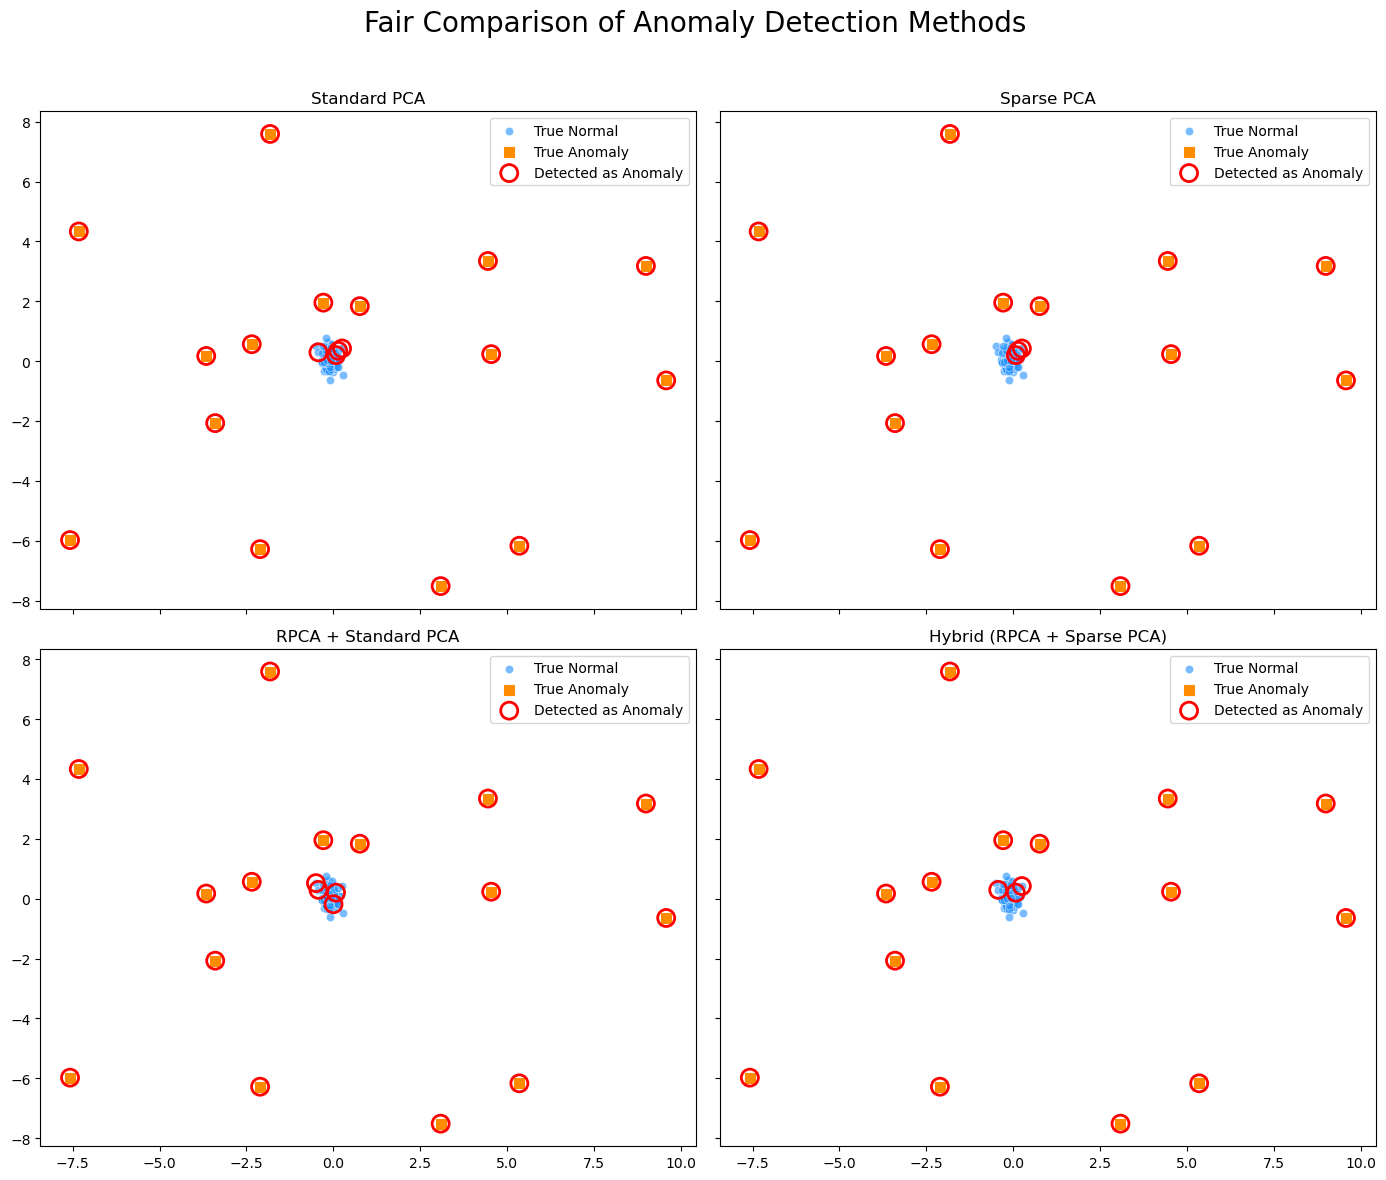

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import svds
from sklearn.metrics import classification_report

# ==============================================================================
# GitHub: loiccoyle/RPCA/rpca/rpca.py 의 핵심 코드
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M
        self.S = np.zeros(self.M.shape)
        self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda

    @staticmethod
    def _shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def fit(self, max_iter=1000, tol=1e-7):
        i = 0
        err = np.inf
        Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            U, s, Vt = svds(self.M - self.S, k=min(self.M.shape)-1)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S
# ==============================================================================

# --- 1. 데이터 생성 ---
np.random.seed(42)
n_features = 10
n_informative_features = 3
true_weights = np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)

# 1-1. 학습 데이터 (이상치 포함)
n_train_samples = 200
latent_train = np.random.randn(n_train_samples, n_informative_features)
X_train_true = latent_train @ true_weights + 0.1 * np.random.randn(n_train_samples, n_features)
n_outliers_train = 20
outlier_indices_train = np.random.choice(n_train_samples, n_outliers_train, replace=False)
X_train_contaminated = X_train_true.copy()
X_train_contaminated[outlier_indices_train] += 15 * (np.random.rand(n_outliers_train, n_features) - 0.5)

# 1-2. (신규) 임계치 설정을 위한 깨끗한 검증 세트 (정상 데이터만)
n_val_samples = 100
latent_val = np.random.randn(n_val_samples, n_informative_features)
X_val_normal = latent_val @ true_weights + 0.1 * np.random.randn(n_val_samples, n_features)

# 1-3. 테스트 데이터 (정상 + 이상)
n_test_samples = 100
n_outliers_test = 15
latent_test = np.random.randn(n_test_samples, n_informative_features)
X_test = latent_test @ true_weights + 0.1 * np.random.randn(n_test_samples, n_features)
outlier_indices_test = np.random.choice(n_test_samples, n_outliers_test, replace=False)
X_test[outlier_indices_test] += 15 * (np.random.rand(n_outliers_test, n_features) - 0.5)
y_test_true = np.zeros(n_test_samples)
y_test_true[outlier_indices_test] = 1

# 1-4. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_contaminated)
X_val_scaled = scaler.transform(X_val_normal) # 검증 세트 스케일링
X_test_scaled = scaler.transform(X_test)

# --- 2. 모델 학습 및 "공정한" 임계치 설정 ---

def get_reconstruction_errors(X, model):
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

# Model 1: Standard PCA
print("Training & Evaluating Detector 1: Standard PCA")
detector_pca = PCA(n_components=n_informative_features)
detector_pca.fit(X_train_scaled)
errors_val_pca = get_reconstruction_errors(X_val_scaled, detector_pca) # 깨끗한 검증 세트로 오차 계산
threshold_pca = np.mean(errors_val_pca) + 3.0 * np.std(errors_val_pca)

# Model 2: Sparse PCA
print("Training & Evaluating Detector 2: Sparse PCA")
detector_spca = SparsePCA(n_components=n_informative_features, alpha=1.0, random_state=42)
detector_spca.fit(X_train_scaled)
errors_val_spca = get_reconstruction_errors(X_val_scaled, detector_spca) # 깨끗한 검증 세트로 오차 계산
threshold_spca = np.mean(errors_val_spca) + 3.0 * np.std(errors_val_spca)

# RPCA로 데이터 정제
print("\nCleaning data with RPCA for robust models...")
decomposer = RPCADecomposition(X_train_scaled)
L_matrix, _ = decomposer.fit(max_iter=1000, tol=1e-7)

# Model 3: RPCA + Standard PCA
print("Training & Evaluating Detector 3: RPCA + Standard PCA")
detector_rpca_pca = PCA(n_components=n_informative_features)
detector_rpca_pca.fit(L_matrix)
errors_val_rpca_pca = get_reconstruction_errors(X_val_scaled, detector_rpca_pca) # 깨끗한 검증 세트로 오차 계산
threshold_rpca_pca = np.mean(errors_val_rpca_pca) + 3.0 * np.std(errors_val_rpca_pca)

# Model 4: Hybrid (RPCA + Sparse PCA)
print("Training & Evaluating Detector 4: Hybrid (RPCA + Sparse PCA)")
detector_hybrid = SparsePCA(n_components=n_informative_features, alpha=1.0, random_state=42)
detector_hybrid.fit(L_matrix)
errors_val_hybrid = get_reconstruction_errors(X_val_scaled, detector_hybrid) # 깨끗한 검증 세트로 오차 계산
threshold_hybrid = np.mean(errors_val_hybrid) + 3.0 * np.std(errors_val_hybrid)

# --- 3. 테스트 데이터에 대한 이상 탐지 ---
y_pred_pca = (get_reconstruction_errors(X_test_scaled, detector_pca) > threshold_pca).astype(int)
y_pred_spca = (get_reconstruction_errors(X_test_scaled, detector_spca) > threshold_spca).astype(int)
y_pred_rpca_pca = (get_reconstruction_errors(X_test_scaled, detector_rpca_pca) > threshold_rpca_pca).astype(int)
y_pred_hybrid = (get_reconstruction_errors(X_test_scaled, detector_hybrid) > threshold_hybrid).astype(int)

# --- 4. 결과 평가 및 시각화 ---
print("\n" + "="*60)
print("             Fair Performance Comparison Results")
print("="*60)
print("\n--- 1. Standard PCA ---")
print(classification_report(y_test_true, y_pred_pca, target_names=['Normal', 'Anomaly'], zero_division=0))
print("\n--- 2. Sparse PCA ---")
print(classification_report(y_test_true, y_pred_spca, target_names=['Normal', 'Anomaly'], zero_division=0))
print("\n--- 3. RPCA + Standard PCA ---")
print(classification_report(y_test_true, y_pred_rpca_pca, target_names=['Normal', 'Anomaly'], zero_division=0))
print("\n--- 4. Hybrid (RPCA + Sparse PCA) ---")
print(classification_report(y_test_true, y_pred_hybrid, target_names=['Normal', 'Anomaly'], zero_division=0))

# 시각화 (동일)
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.suptitle('Fair Comparison of Anomaly Detection Methods', fontsize=20)
pca_vis = PCA(n_components=2)
X_test_vis = pca_vis.fit_transform(X_test_scaled)
models = {
    'Standard PCA': y_pred_pca,
    'Sparse PCA': y_pred_spca,
    'RPCA + Standard PCA': y_pred_rpca_pca,
    'Hybrid (RPCA + Sparse PCA)': y_pred_hybrid
}
for ax, (title, y_pred) in zip(axes.flatten(), models.items()):
    sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
    sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
    detected_indices = np.where(y_pred == 1)[0]
    ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1], s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
    ax.set_title(title)
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

--- 1. Standard PCA ---
              precision    recall  f1-score   support

      Normal       1.00      0.91      0.95        85
     Anomaly       0.65      1.00      0.79        15

    accuracy                           0.92       100
   macro avg       0.83      0.95      0.87       100
weighted avg       0.95      0.92      0.93       100


--- 2. Sparse PCA ---
              precision    recall  f1-score   support

      Normal       1.00      0.94      0.97        85
     Anomaly       0.75      1.00      0.86        15

    accuracy                           0.95       100
   macro avg       0.88      0.97      0.91       100
weighted avg       0.96      0.95      0.95       100


Cleaning data with RPCA for robust models...

--- 3. RPCA + Standard PCA ---
              precision    recall  f1-score   support

      Normal       1.00      0.94      0.97        85
     Anomaly       0.75      1.00      0.86        15

    accuracy                           0.95       100
   

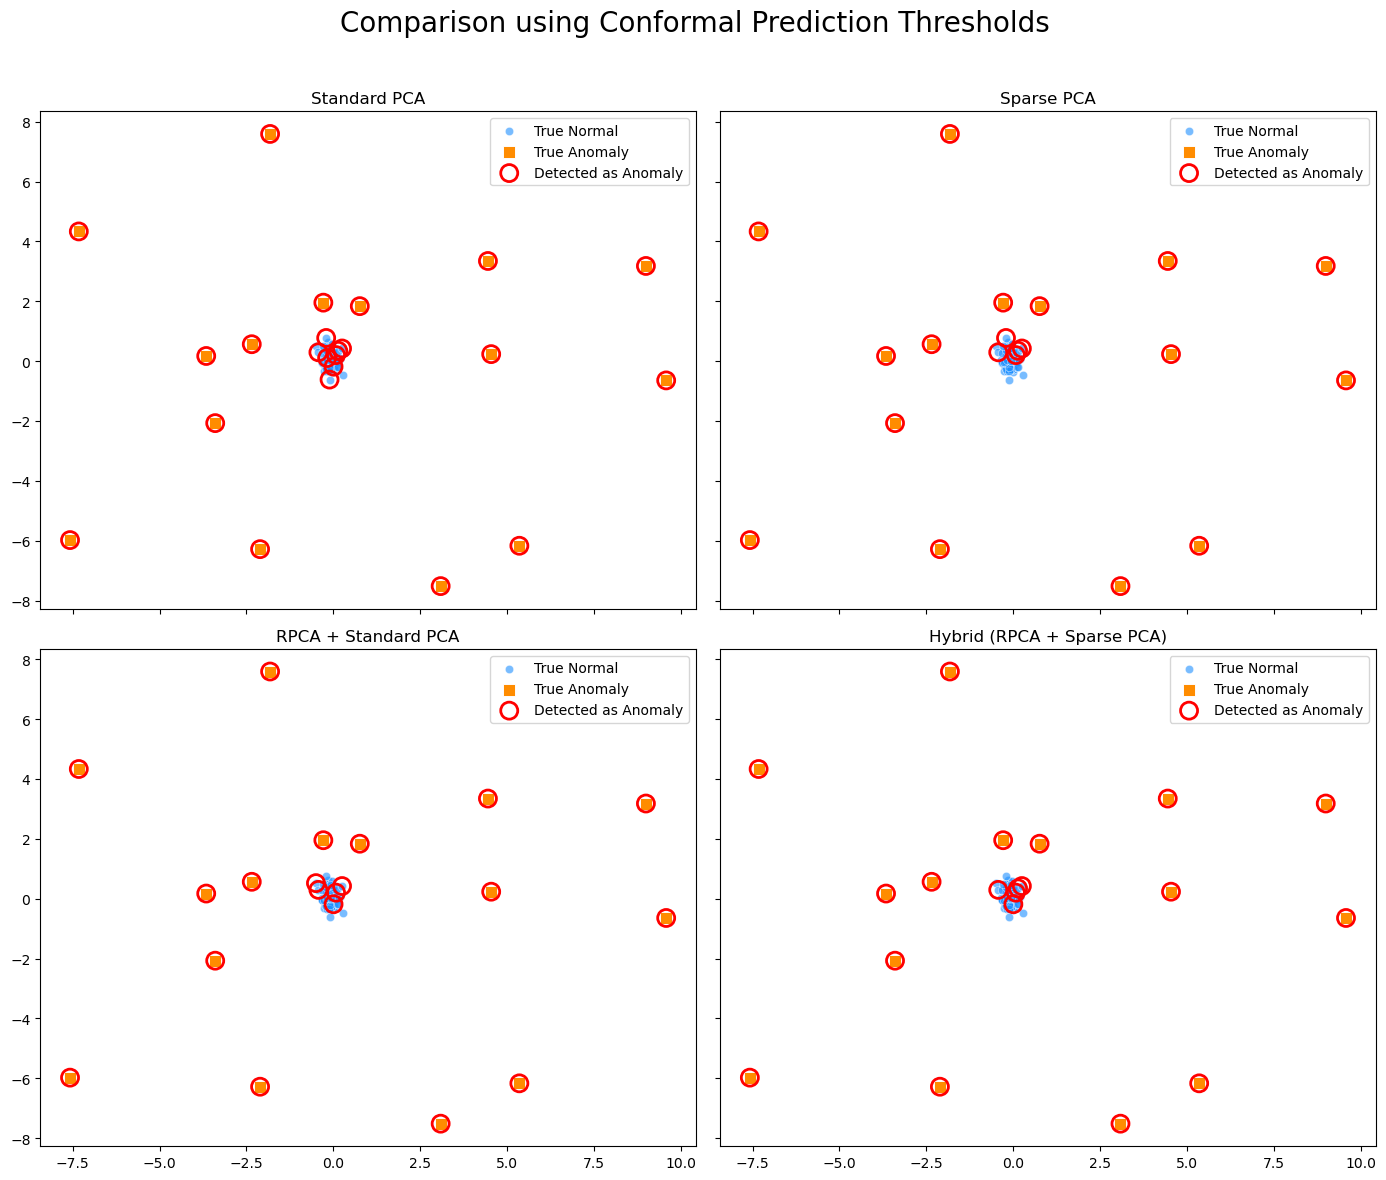

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mapie.regression import MapieRegressor
from sklearn.metrics import classification_report

# ==============================================================================
# GitHub: loiccoyle/RPCA/rpca/rpca.py 의 핵심 코드
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M; self.S = np.zeros(self.M.shape); self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda
    @staticmethod
    def _shrink(M, tau): return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))
    def fit(self, max_iter=1000, tol=1e-7):
        i = 0; err = np.inf; Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            k = min(self.M.shape) - 1
            if k <= 0: break
            from scipy.sparse.linalg import svds
            U, s, Vt = svds(self.M - self.S, k=k)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S

# --- 1. 데이터 생성 ---
# ... (데이터 생성 코드는 이전과 동일) ...
np.random.seed(42)
n_features=10; n_informative_features=3
true_weights=np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)
n_train_samples=200; latent_train=np.random.randn(n_train_samples, n_informative_features)
X_train_true=latent_train @ true_weights + 0.1 * np.random.randn(n_train_samples, n_features)
n_outliers_train=20; outlier_indices_train=np.random.choice(n_train_samples, n_outliers_train, replace=False)
X_train_contaminated=X_train_true.copy(); X_train_contaminated[outlier_indices_train] += 15*(np.random.rand(n_outliers_train, n_features)-0.5)
n_cal_samples=100; latent_cal=np.random.randn(n_cal_samples, n_informative_features)
X_cal_normal=latent_cal @ true_weights + 0.1 * np.random.randn(n_cal_samples, n_features)
n_test_samples=100; n_outliers_test=15; latent_test=np.random.randn(n_test_samples, n_informative_features)
X_test=latent_test @ true_weights + 0.1 * np.random.randn(n_test_samples, n_features)
outlier_indices_test=np.random.choice(n_test_samples, n_outliers_test, replace=False)
X_test[outlier_indices_test] += 15 * (np.random.rand(n_outliers_test, n_features) - 0.5)
y_test_true=np.zeros(n_test_samples); y_test_true[outlier_indices_test]=1
scaler=StandardScaler(); X_train_scaled=scaler.fit_transform(X_train_contaminated)
X_cal_scaled=scaler.transform(X_cal_normal); X_test_scaled=scaler.transform(X_test)


# --- 2. 모델 및 파이프라인 정의 ---
# 복원 오차를 계산하는 간단한 함수 (MAPIE 대신 사용)
def get_reconstruction_errors(X, model):
    if not hasattr(model, 'components_'):
        raise TypeError("Model must be a fitted PCA-like estimator with 'transform' and 'inverse_transform' methods.")
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

alpha = 0.01  # 10%의 예상 오탐율 (99% 신뢰수준)
quantile_level = 1 - alpha
all_predictions = {}

# --- 3. 모델별 학습, 보정 및 평가 ---

# Model 1: Standard PCA
print("--- 1. Standard PCA ---")
detector_pca = PCA(n_components=n_informative_features)
detector_pca.fit(X_train_scaled)
cal_scores_pca = get_reconstruction_errors(X_cal_scaled, detector_pca)
threshold_pca = np.quantile(cal_scores_pca, quantile_level)
test_scores_pca = get_reconstruction_errors(X_test_scaled, detector_pca)
all_predictions['Standard PCA'] = (test_scores_pca > threshold_pca).astype(int)
print(classification_report(y_test_true, all_predictions['Standard PCA'], target_names=['Normal', 'Anomaly'], zero_division=0))

# Model 2: Sparse PCA
print("\n--- 2. Sparse PCA ---")
detector_spca = SparsePCA(n_components=n_informative_features, alpha=1.0, random_state=42)
detector_spca.fit(X_train_scaled)
cal_scores_spca = get_reconstruction_errors(X_cal_scaled, detector_spca)
threshold_spca = np.quantile(cal_scores_spca, quantile_level)
test_scores_spca = get_reconstruction_errors(X_test_scaled, detector_spca)
all_predictions['Sparse PCA'] = (test_scores_spca > threshold_spca).astype(int)
print(classification_report(y_test_true, all_predictions['Sparse PCA'], target_names=['Normal', 'Anomaly'], zero_division=0))

# RPCA로 데이터 정제
print("\nCleaning data with RPCA for robust models...")
decomposer = RPCADecomposition(X_train_scaled)
L_matrix, _ = decomposer.fit()

# Model 3: RPCA + Standard PCA
print("\n--- 3. RPCA + Standard PCA ---")
detector_rpca_pca = PCA(n_components=n_informative_features)
detector_rpca_pca.fit(L_matrix)
cal_scores_rpca_pca = get_reconstruction_errors(X_cal_scaled, detector_rpca_pca)
threshold_rpca_pca = np.quantile(cal_scores_rpca_pca, quantile_level)
test_scores_rpca_pca = get_reconstruction_errors(X_test_scaled, detector_rpca_pca)
all_predictions['RPCA + Standard PCA'] = (test_scores_rpca_pca > threshold_rpca_pca).astype(int)
print(classification_report(y_test_true, all_predictions['RPCA + Standard PCA'], target_names=['Normal', 'Anomaly'], zero_division=0))

# Model 4: Hybrid (RPCA + Sparse PCA)
print("\n--- 4. Hybrid (RPCA + Sparse PCA) ---")
detector_hybrid = SparsePCA(n_components=n_informative_features, alpha=1.0, random_state=42)
detector_hybrid.fit(L_matrix)
cal_scores_hybrid = get_reconstruction_errors(X_cal_scaled, detector_hybrid)
threshold_hybrid = np.quantile(cal_scores_hybrid, quantile_level)
test_scores_hybrid = get_reconstruction_errors(X_test_scaled, detector_hybrid)
all_predictions['Hybrid (RPCA + Sparse PCA)'] = (test_scores_hybrid > threshold_hybrid).astype(int)
print(classification_report(y_test_true, all_predictions['Hybrid (RPCA + Sparse PCA)'], target_names=['Normal', 'Anomaly'], zero_division=0))


# --- 4. 시각화 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.suptitle('Comparison using Conformal Prediction Thresholds', fontsize=20)
pca_vis = PCA(n_components=2)
X_test_vis = pca_vis.fit_transform(X_test_scaled)

for ax, (title, y_pred) in zip(axes.flatten(), all_predictions.items()):
    sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
    sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
    detected_indices = np.where(y_pred == 1)[0]
    ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1],
			s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
    ax.set_title(title)
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---

**1 Fixed Calibration Set:** The method from our previous discussion, which uses a single, fixed set of clean data to establish the threshold.

**2. Resampling (K-Fold CV):** The newer method you asked for, which uses cross-validation for a more robust and generalizable threshold.

## **Advantages of Resampling (K-Fold Cross-Validation)**

Relying on a single train/calibration split can be sensitive to the specific data points that happen to land in the calibration set. Using K-Fold Cross-Validation for resampling helps solve this:

1. **Stable Threshold:** By averaging the outcome over several different data splits (K folds), we get a more stable and reliable threshold that is less dependent on randomness.

2. **Efficient Data Use:** Every data point in our "normal pool" gets used for calibration exactly once, ensuring we leverage our data efficiently.

3. **Improved Generalization:** A more stable threshold, representing the model's out-of-sample error distribution more accurately, leads to better and more consistent performance on new, unseen data.

METHOD 1: Evaluating with a Fixed Calibration Set
--- Processing: Standard PCA (Fixed Split) ---
--- Processing: Sparse PCA (Fixed Split) ---
--- Processing: RPCA + Standard PCA (Fixed Split) ---
--- Processing: Hybrid (RPCA + Sparse PCA) (Fixed Split) ---

METHOD 2: Evaluating with a Resampling (K-Fold) Method
--- Processing: Standard PCA (Resampling) ---
--- Processing: Sparse PCA (Resampling) ---
--- Processing: RPCA + Standard PCA (Resampling) ---
--- Processing: Hybrid (RPCA + Sparse PCA) (Resampling) ---


             FINAL PERFORMANCE COMPARISON

--- Standard PCA ---
--- (Fixed Split Method) ---
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94        85
     Anomaly       0.62      1.00      0.77        15

    accuracy                           0.91       100
   macro avg       0.81      0.95      0.86       100
weighted avg       0.94      0.91      0.92       100

--- (Resampling Method) ---
              precision    recall 

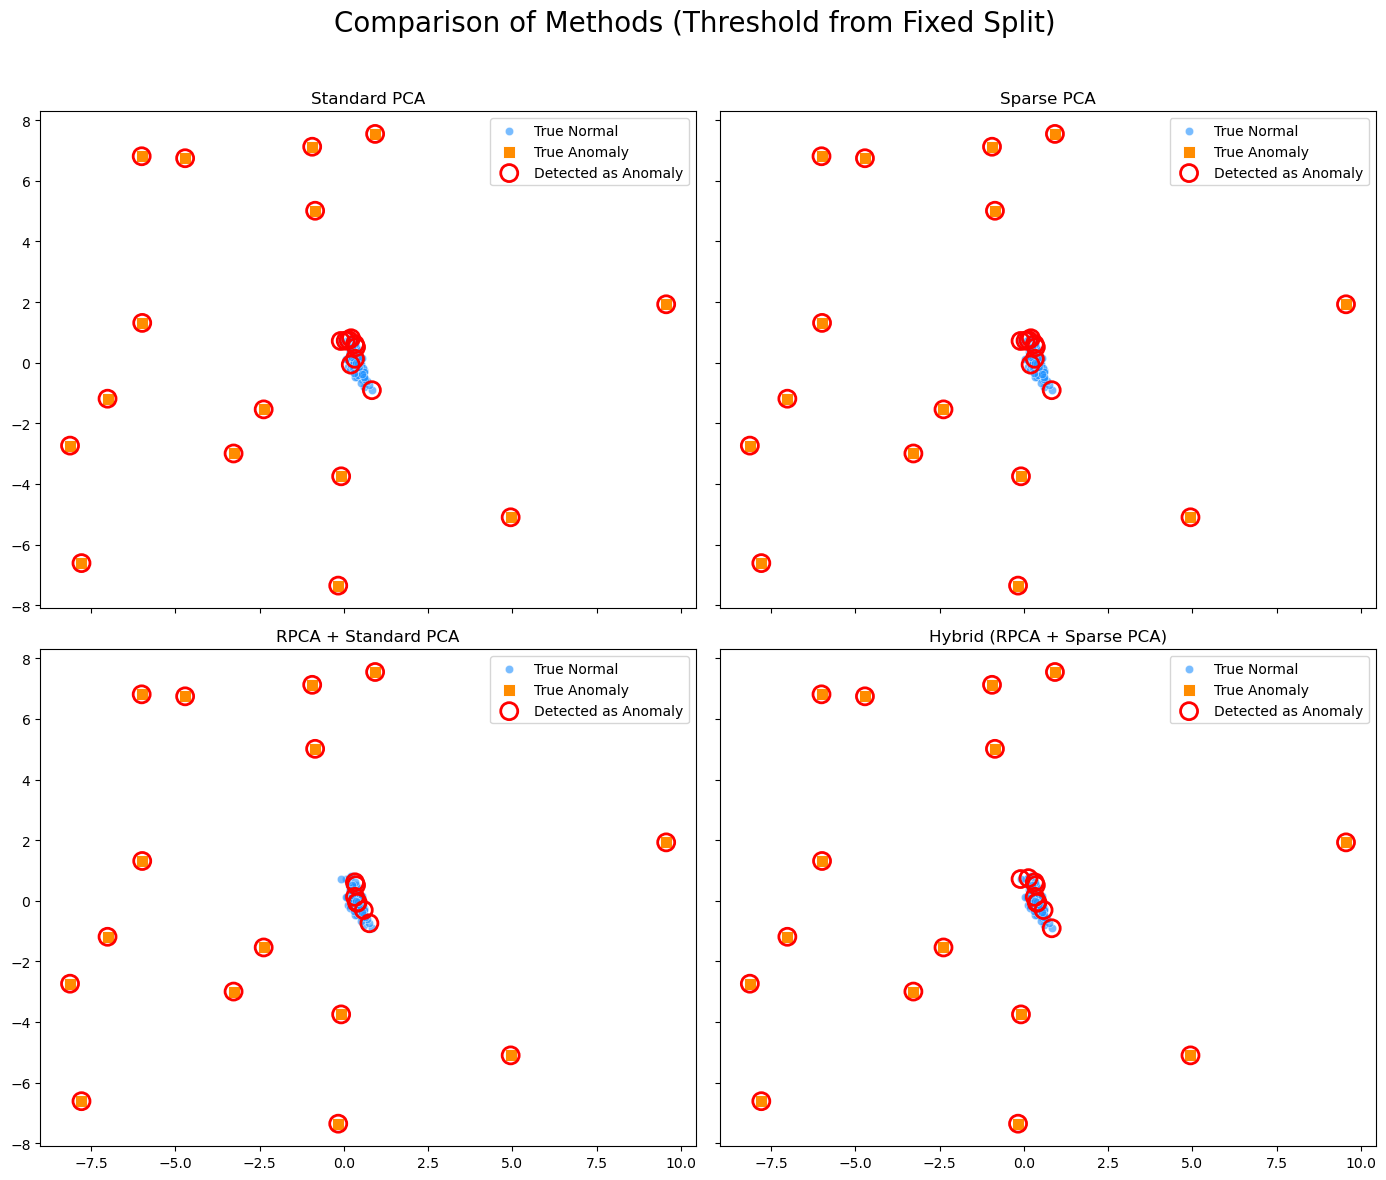

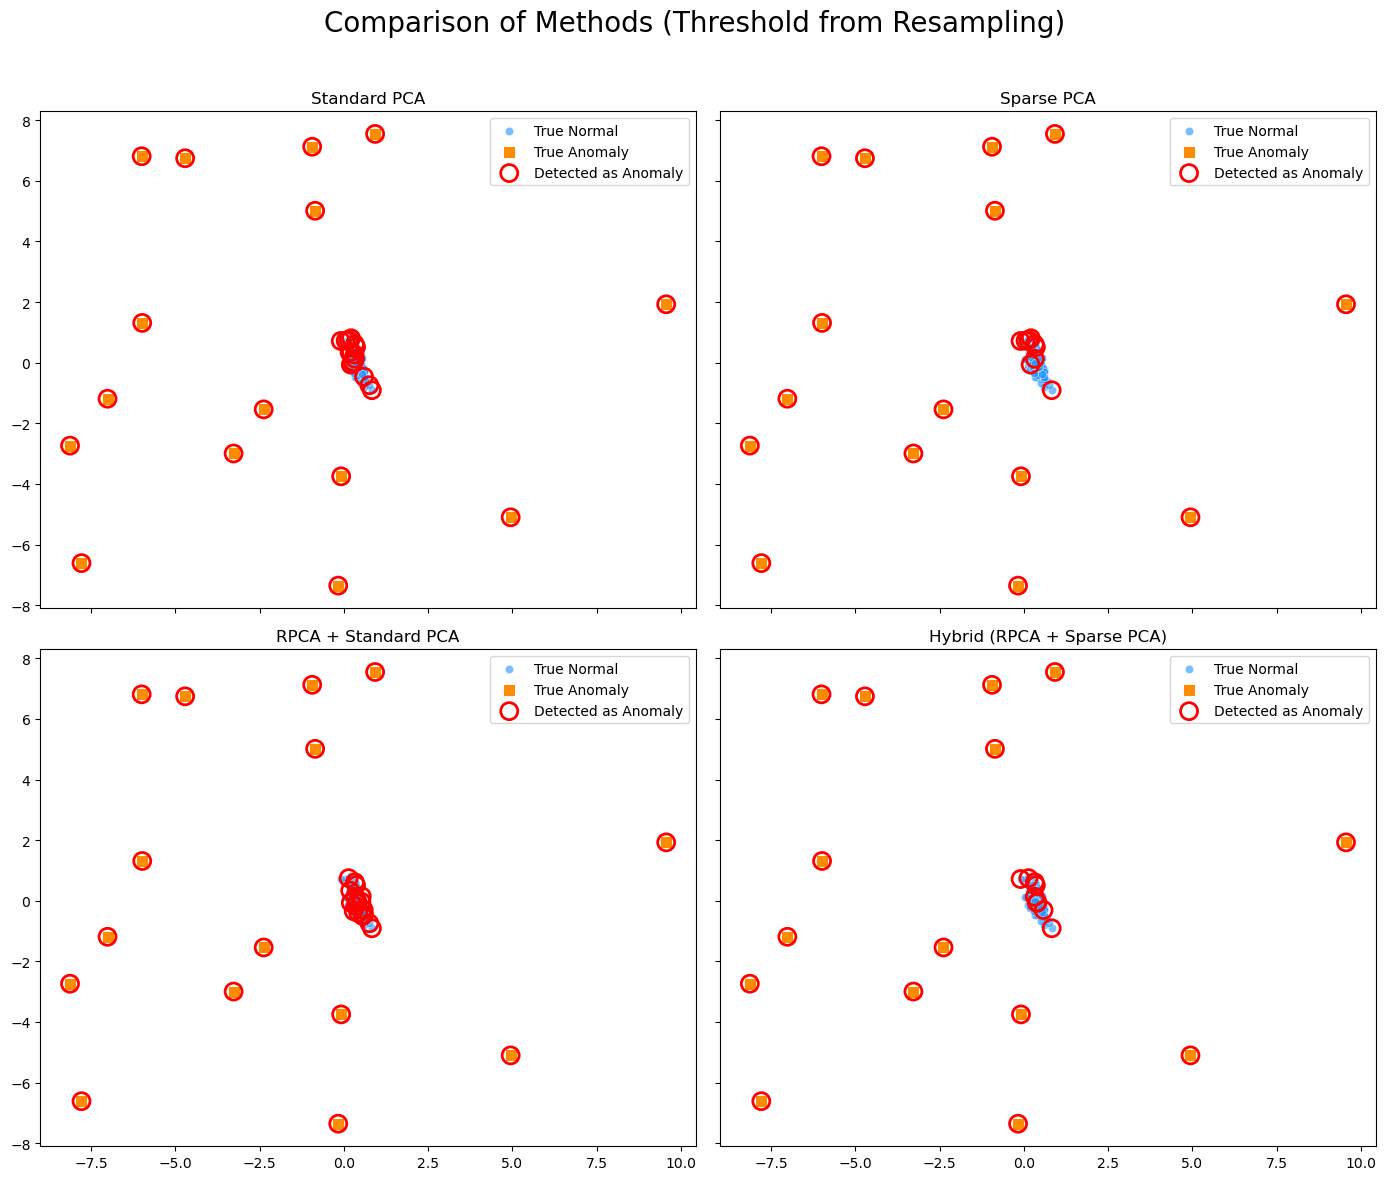

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# ==============================================================================
# RPCA Implementation (from GitHub: loiccoyle/RPCA)
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M; self.S = np.zeros(self.M.shape); self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda
    @staticmethod
    def _shrink(M, tau): return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))
    def fit(self, max_iter=1000, tol=1e-7):
        i = 0; err = np.inf; Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            k = min(self.M.shape) - 1
            if k <= 0: break
            from scipy.sparse.linalg import svds
            U, s, Vt = svds(self.M - self.S, k=k)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S

# --- 1. Data Generation ---
np.random.seed(42)
n_features=10; n_informative_features=3
true_weights=np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)

# Generate distinct datasets
latent_train = np.random.randn(200, n_informative_features)
X_train_normal_true = latent_train @ true_weights + 0.1 * np.random.randn(200, n_features)
latent_cal = np.random.randn(100, n_informative_features)
X_cal_normal = latent_cal @ true_weights + 0.1 * np.random.randn(100, n_features)

# Test Data
n_test_samples=100; n_outliers_test=15
latent_test = np.random.randn(n_test_samples, n_informative_features)
X_test = latent_test @ true_weights + 0.1 * np.random.randn(n_test_samples, n_features)
outlier_indices_test = np.random.choice(n_test_samples, n_outliers_test, replace=False)
X_test[outlier_indices_test] += 15 * (np.random.rand(n_outliers_test, n_features) - 0.5)
y_test_true = np.zeros(n_test_samples); y_test_true[outlier_indices_test]=1

# Contamination function and final training set
def contaminate(X, n_outliers_rate=0.1, magnitude=15):
    X_contaminated = X.copy()
    n_samples, n_features = X.shape
    n_outliers = int(n_samples * n_outliers_rate)
    if n_outliers == 0: return X_contaminated
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    X_contaminated[outlier_indices] += magnitude * (np.random.rand(n_outliers, n_features) - 0.5)
    return X_contaminated

X_train_contaminated = contaminate(X_train_normal_true, n_outliers_rate=0.1)

# Scaling
scaler = StandardScaler()
scaler.fit(X_train_contaminated)
X_cal_scaled = scaler.transform(X_cal_normal)
X_test_scaled = scaler.transform(X_test)

# --- 2. Define Models and Parameters ---
alpha = 0.1
quantile_level = 1 - alpha
all_predictions = {"Fixed Split": {}, "Resampling": {}}
model_configs = {
    "Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": False},
    "Sparse PCA": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": False},
    "RPCA + Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": True},
    "Hybrid (RPCA + Sparse PCA)": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": True}
}

def get_reconstruction_errors(X, model):
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

# --- 3. METHOD 1: THRESHOLD FROM A FIXED CALIBRATION SET ---
print("="*60 + "\nMETHOD 1: Evaluating with a Fixed Calibration Set\n" + "="*60)
for title, config in model_configs.items():
    print(f"--- Processing: {title} (Fixed Split) ---")
    # Train final model on the full training set
    if config["use_rpca"]:
        decomposer = RPCADecomposition(X_train_contaminated)
        L_matrix, _ = decomposer.fit()
        final_model = config["model"].fit(L_matrix)
    else:
        final_model = config["model"].fit(X_train_contaminated)
    
    # Get threshold from the single, fixed calibration set
    cal_scores = get_reconstruction_errors(X_cal_scaled, final_model)
    threshold = np.quantile(cal_scores, quantile_level)
    
    # Evaluate on test set
    test_scores = get_reconstruction_errors(X_test_scaled, final_model)
    all_predictions["Fixed Split"][title] = (test_scores > threshold).astype(int)

# --- 4. METHOD 2: THRESHOLD FROM K-FOLD RESAMPLING ---
print("\n" + "="*60 + "\nMETHOD 2: Evaluating with a Resampling (K-Fold) Method\n" + "="*60)
X_cv_pool_normal = np.vstack([X_train_normal_true, X_cal_normal])
X_cv_pool_scaled = scaler.transform(X_cv_pool_normal)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for title, config in model_configs.items():
    print(f"--- Processing: {title} (Resampling) ---")
    cal_scores_resampled = []
    for train_idx, cal_idx in kf.split(X_cv_pool_scaled):
        X_train_fold, X_cal_fold = X_cv_pool_scaled[train_idx], X_cv_pool_scaled[cal_idx]
        
        # Simulate the actual training environment for each fold
        if config["use_rpca"]:
            X_train_fold_contaminated = contaminate(X_train_fold)
            decomposer = RPCADecomposition(X_train_fold_contaminated)
            L_matrix, _ = decomposer.fit()
            if L_matrix.shape[0] < n_informative_features: continue
            current_model = config["model"].fit(L_matrix)
        else:
            X_train_fold_contaminated = contaminate(X_train_fold)
            current_model = config["model"].fit(X_train_fold_contaminated)

        errors = get_reconstruction_errors(X_cal_fold, current_model)
        cal_scores_resampled.extend(errors)
    
    # Calculate robust threshold from all out-of-sample scores
    resampling_threshold = np.quantile(cal_scores_resampled, quantile_level)
    
    # Train final model (as before) to test with the robust threshold
    if config["use_rpca"]:
        decomposer = RPCADecomposition(X_train_contaminated)
        L_matrix, _ = decomposer.fit()
        final_model = config["model"].fit(L_matrix)
    else:
        final_model = config["model"].fit(X_train_contaminated)
        
    test_scores = get_reconstruction_errors(X_test_scaled, final_model)
    all_predictions["Resampling"][title] = (test_scores > resampling_threshold).astype(int)

# --- 5. Print and Visualize All Results ---
print("\n\n" + "="*60 + "\n             FINAL PERFORMANCE COMPARISON\n" + "="*60)
for model_name in model_configs.keys():
    print(f"\n--- {model_name} ---")
    print("--- (Fixed Split Method) ---")
    print(classification_report(y_test_true, all_predictions["Fixed Split"][model_name], target_names=['Normal', 'Anomaly'], zero_division=0))
    print("--- (Resampling Method) ---")
    print(classification_report(y_test_true, all_predictions["Resampling"][model_name], target_names=['Normal', 'Anomaly'], zero_division=0))

# Create two sets of plots
for method_name in ["Fixed Split", "Resampling"]:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    fig.suptitle(f'Comparison of Methods (Threshold from {method_name})', fontsize=20)
    pca_vis = PCA(n_components=2)
    X_test_vis = pca_vis.fit_transform(X_test_scaled)
    
    for ax, (title, model_config) in zip(axes.flatten(), model_configs.items()):
        y_pred = all_predictions[method_name][title]
        sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
        sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
        detected_indices = np.where(y_pred == 1)[0]
        ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1],
                   s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
        ax.set_title(title)
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

---

**Key Difference: The Underlying Assumption**

The core difference between these two methods lies in the assumptions they make about the distribution of reconstruction errors:

1. **Conformal Prediction (Quantile Method) 🎯**

   - **Assumption-Free:** This method makes no assumptions about the shape of the error distribution. It works directly with the actual, empirical distribution of the errors collected during resampling.

   - **How it works:** It finds the exact data point (quantile) below which a certain percentage of the observed errors fall. By setting the threshold at the (1-α) quantile (e.g., 95th percentile), you are making a direct, data-driven decision based on the desired false positive rate α.

2. **3-Sigma Rule (Normal Distribution Assumption) 🔔**

   - **Assumes Normality:** This method implicitly assumes that the reconstruction errors follow a Normal (Gaussian) distribution (a "bell curve").

   - **How it works:** It calculates the mean and standard deviation and sets a threshold at `mean + 3*std`. In a perfect Normal distribution, this cutoff contains 99.7% of the data. However, if the actual error distribution is skewed or has long tails (which is common), this assumption is violated, and the threshold may be too strict or too lenient.

By comparing them side-by-side, we can see which assumption holds better for our problem.

--- Processing: Standard PCA ---
--- Processing: Sparse PCA ---
--- Processing: RPCA + Standard PCA ---
--- Processing: Hybrid (RPCA + Sparse PCA) ---


      FINAL PERFORMANCE: Conformal vs. 3-Sigma

--- Standard PCA ---
--- (Threshold: Conformal Prediction) ---
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96        85
     Anomaly       0.68      1.00      0.81        15

    accuracy                           0.93       100
   macro avg       0.84      0.96      0.88       100
weighted avg       0.95      0.93      0.94       100

--- (Threshold: 3-Sigma Rule) ---
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99        85
     Anomaly       0.88      1.00      0.94        15

    accuracy                           0.98       100
   macro avg       0.94      0.99      0.96       100
weighted avg       0.98      0.98      0.98       100


--- Sparse PCA ---
--- (Threshold: Conformal Pr

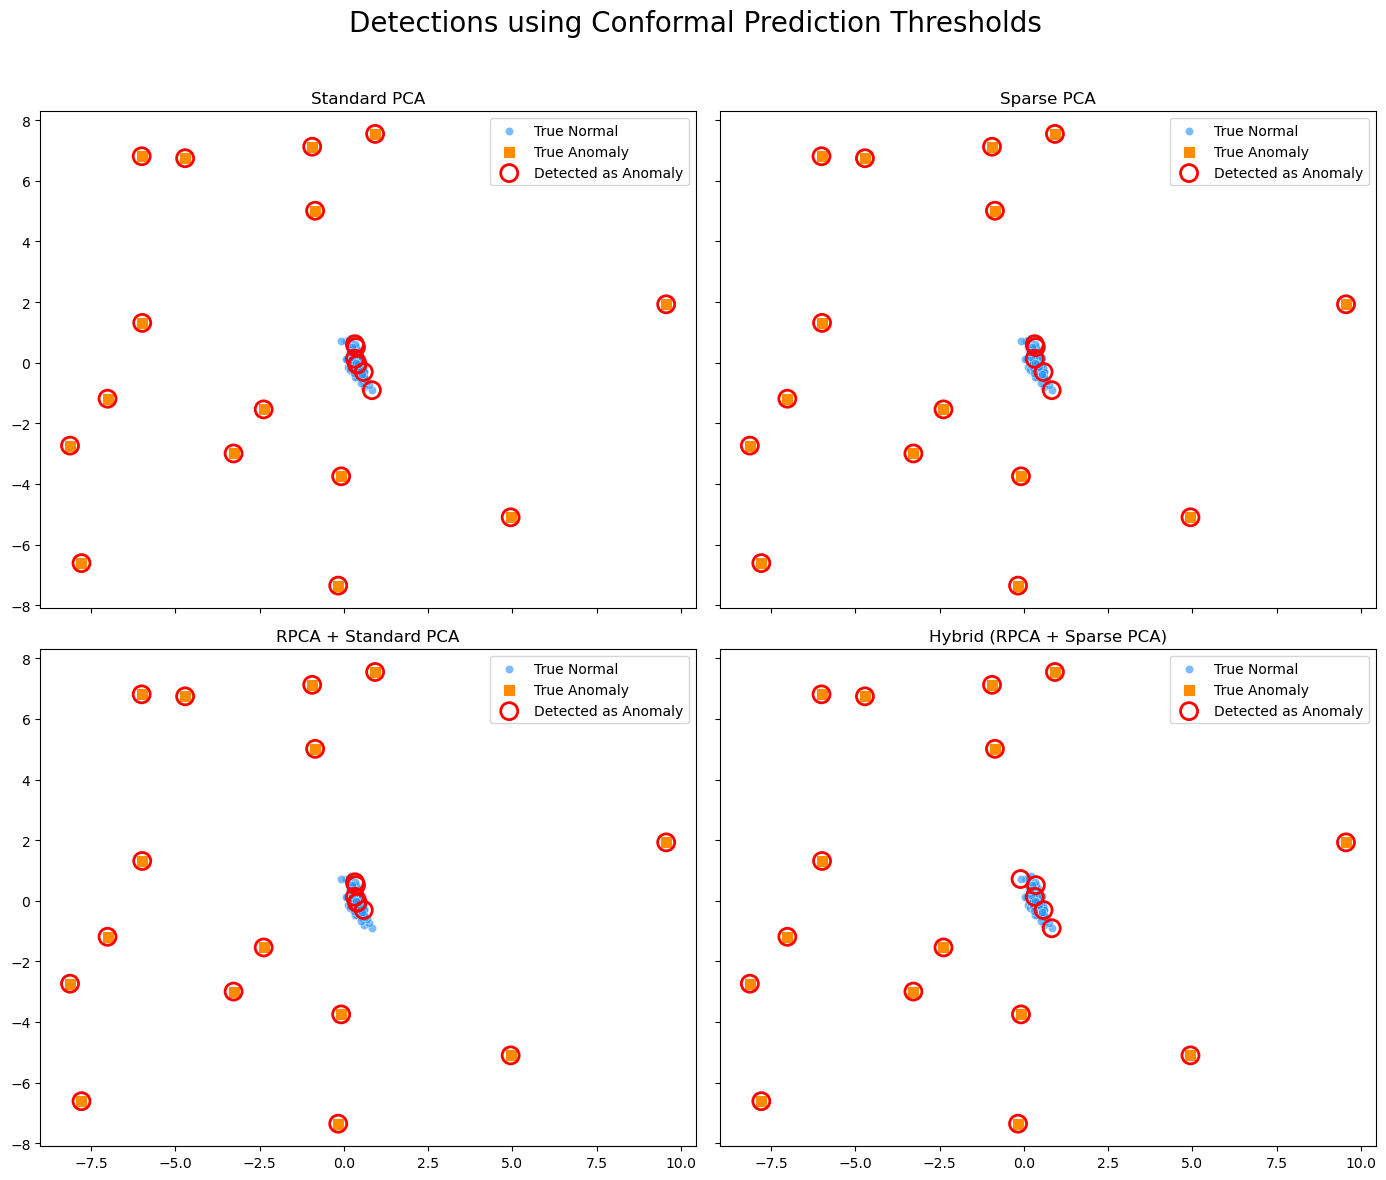

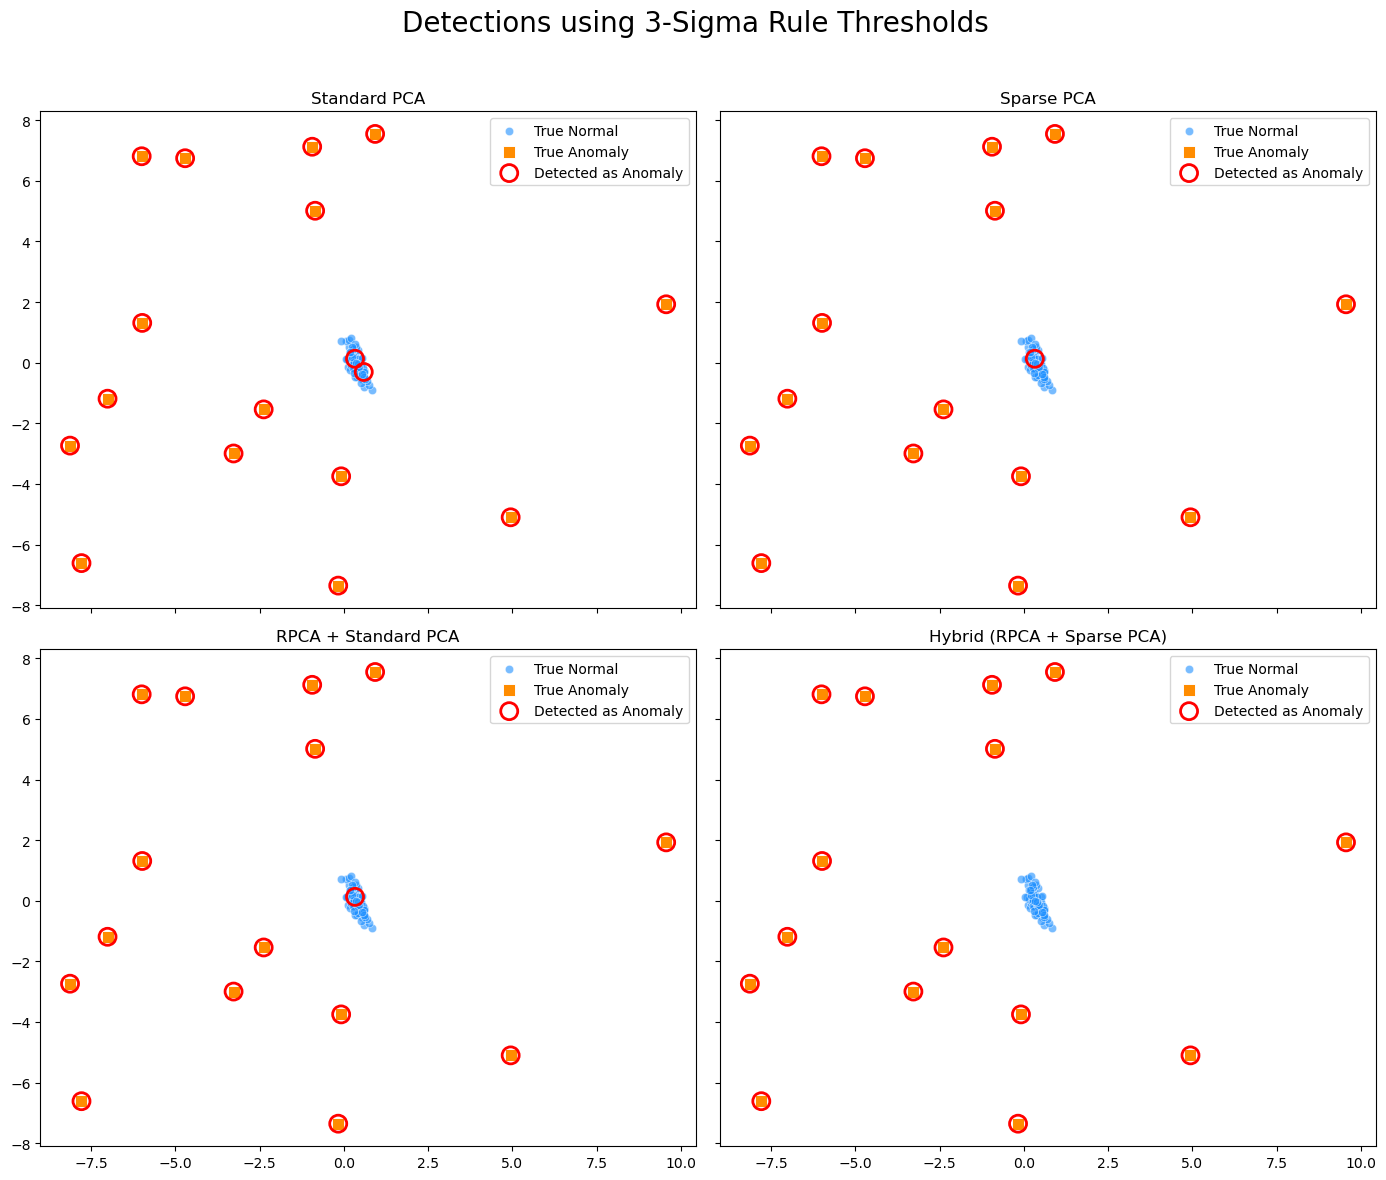

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# ==============================================================================
# RPCA Implementation (from GitHub: loiccoyle/RPCA)
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M; self.S = np.zeros(self.M.shape); self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda
    @staticmethod
    def _shrink(M, tau): return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))
    def fit(self, max_iter=1000, tol=1e-7):
        i = 0; err = np.inf; Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            k = min(self.M.shape) - 1
            if k <= 0: break
            from scipy.sparse.linalg import svds
            U, s, Vt = svds(self.M - self.S, k=k)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S

# --- 1. Data Generation ---
np.random.seed(42)
n_features=10; n_informative_features=3
true_weights=np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)

# Generate datasets
latent_train = np.random.randn(200, n_informative_features)
X_train_normal_true = latent_train @ true_weights + 0.1 * np.random.randn(200, n_features)
latent_cal = np.random.randn(100, n_informative_features)
X_cal_normal = latent_cal @ true_weights + 0.1 * np.random.randn(100, n_features)
X_cv_pool_normal = np.vstack([X_train_normal_true, X_cal_normal])

# Test Data
n_test_samples=100; n_outliers_test=15
latent_test = np.random.randn(n_test_samples, n_informative_features)
X_test = latent_test @ true_weights + 0.1 * np.random.randn(n_test_samples, n_features)
outlier_indices_test=np.random.choice(n_test_samples, n_outliers_test, replace=False)
X_test[outlier_indices_test] += 15 * (np.random.rand(n_outliers_test, n_features) - 0.5)
y_test_true = np.zeros(n_test_samples); y_test_true[outlier_indices_test]=1

# Contamination function
def contaminate(X, n_outliers_rate=0.1, magnitude=15):
    X_contaminated = X.copy()
    n_samples, n_features = X.shape
    n_outliers = int(n_samples * n_outliers_rate)
    if n_outliers == 0: return X_contaminated
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    X_contaminated[outlier_indices] += magnitude * (np.random.rand(n_outliers, n_features) - 0.5)
    return X_contaminated

X_train_contaminated = contaminate(X_train_normal_true)

# Scaling
scaler = StandardScaler()
scaler.fit(X_train_contaminated)
X_cv_pool_scaled = scaler.transform(X_cv_pool_normal)
X_test_scaled = scaler.transform(X_test)

# --- 2. K-Fold Resampling, Threshold Comparison, and Evaluation ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
alpha = 0.05  # Use 5% error rate for Conformal Prediction
quantile_level = 1 - alpha
all_predictions = {}

model_configs = {
    "Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": False},
    "Sparse PCA": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": False},
    "RPCA + Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": True},
    "Hybrid (RPCA + Sparse PCA)": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": True}
}

def get_reconstruction_errors(X, model):
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

for title, config in model_configs.items():
    print(f"--- Processing: {title} ---")
    all_predictions[title] = {}
    
    # Collect calibration scores via resampling
    cal_scores_resampled = []
    for train_idx, cal_idx in kf.split(X_cv_pool_scaled):
        X_train_fold, X_cal_fold = X_cv_pool_scaled[train_idx], X_cv_pool_scaled[cal_idx]
        
        if config["use_rpca"]:
            X_train_fold_contaminated = contaminate(X_train_fold)
            decomposer = RPCADecomposition(X_train_fold_contaminated)
            L_matrix, _ = decomposer.fit()
            if L_matrix.shape[0] < n_informative_features: continue
            current_model = config["model"].fit(L_matrix)
        else:
            X_train_fold_contaminated = contaminate(X_train_fold)
            current_model = config["model"].fit(X_train_fold_contaminated)

        errors = get_reconstruction_errors(X_cal_fold, current_model)
        cal_scores_resampled.extend(errors)
    
    # Calculate TWO thresholds from the SAME calibration scores
    threshold_cp = np.quantile(cal_scores_resampled, quantile_level)
    threshold_3s = np.mean(cal_scores_resampled) + 3 * np.std(cal_scores_resampled)
    
    # Train final model for testing
    if config["use_rpca"]:
        decomposer = RPCADecomposition(scaler.transform(X_train_contaminated))
        L_matrix, _ = decomposer.fit()
        final_model = config["model"].fit(L_matrix)
    else:
        final_model = config["model"].fit(scaler.transform(X_train_contaminated))

    # Evaluate with both thresholds
    test_scores = get_reconstruction_errors(X_test_scaled, final_model)
    all_predictions[title]["Conformal"] = (test_scores > threshold_cp).astype(int)
    all_predictions[title]["3-Sigma"] = (test_scores > threshold_3s).astype(int)

# --- 3. Print and Visualize All Results ---
print("\n\n" + "="*60 + "\n      FINAL PERFORMANCE: Conformal vs. 3-Sigma\n" + "="*60)
for model_name in model_configs.keys():
    print(f"\n--- {model_name} ---")
    print("--- (Threshold: Conformal Prediction) ---")
    print(classification_report(y_test_true, all_predictions[model_name]["Conformal"], target_names=['Normal', 'Anomaly'], zero_division=0))
    print("--- (Threshold: 3-Sigma Rule) ---")
    print(classification_report(y_test_true, all_predictions[model_name]["3-Sigma"], target_names=['Normal', 'Anomaly'], zero_division=0))

# Create two sets of plots for direct comparison
for method_name in ["Conformal", "3-Sigma"]:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    title_prefix = "Conformal Prediction" if method_name == "Conformal" else "3-Sigma Rule"
    fig.suptitle(f'Detections using {title_prefix} Thresholds', fontsize=20)
    
    pca_vis = PCA(n_components=2)
    X_test_vis = pca_vis.fit_transform(X_test_scaled)
    
    for ax, (model_title, model_config) in zip(axes.flatten(), model_configs.items()):
        y_pred = all_predictions[model_title][method_name]
        sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
        sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
        detected_indices = np.where(y_pred == 1)[0]
        ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1],
                   s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
        ax.set_title(model_title)
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

---

#### **The New Scenario: Non-Normally Distributed Data**

The previous example generated data where the reconstruction errors for normal points were close enough to a Normal distribution, which can make the 3-Sigma rule appear effective.

To demonstrate the true strength and robustness of Conformal Prediction, we will now construct a scenario where this assumption is violated.



We will modify the data generation process to create a "normal" data cloud that is inherently skewed. Instead of generating the underlying latent variables from a symmetric Normal distribution (`randn`), we will use a **Chi-squared distribution** (`chisquare`).

**The Consequence:**

- The Chi-squared distribution is not symmetric; it has a long tail to one side.

- This creates a "normal" data cloud that is dense in one area and spreads out in another.

- When a linear model like PCA tries to represent these points, the reconstruction errors for the normal data will **no longer follow a Normal distribution**. They will also be skewed.

This scenario directly challenges the core assumption of the 3-Sigma rule and will highlight the superior, distribution-free nature of Conformal Prediction.

--- Processing: Standard PCA ---
--- Processing: Sparse PCA ---
--- Processing: RPCA + Standard PCA ---
--- Processing: Hybrid (RPCA + Sparse PCA) ---


      FINAL PERFORMANCE: Conformal vs. 3-Sigma on SKEWED Data

--- Standard PCA ---
--- (Threshold: Conformal Prediction) ---
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99        85
     Anomaly       0.94      1.00      0.97        15

    accuracy                           0.99       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.99      0.99      0.99       100

--- (Threshold: 3-Sigma Rule) ---
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99        85
     Anomaly       0.94      1.00      0.97        15

    accuracy                           0.99       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.99      0.99      0.99       100


--- Sparse PCA ---
--- (Threshol

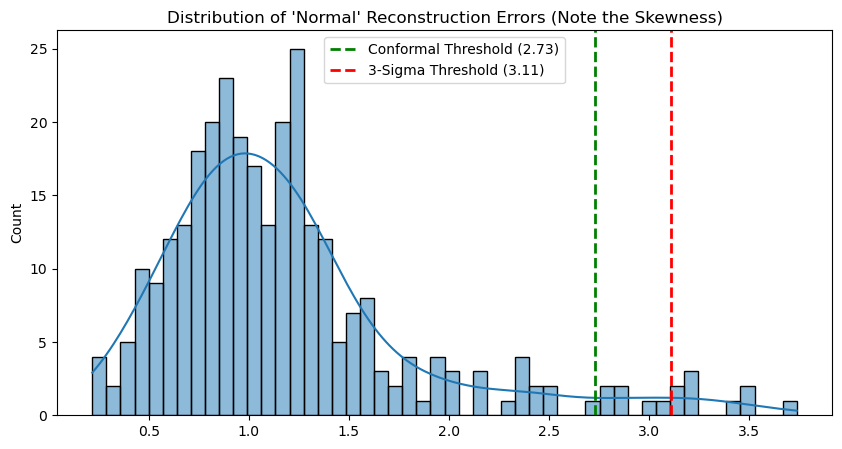

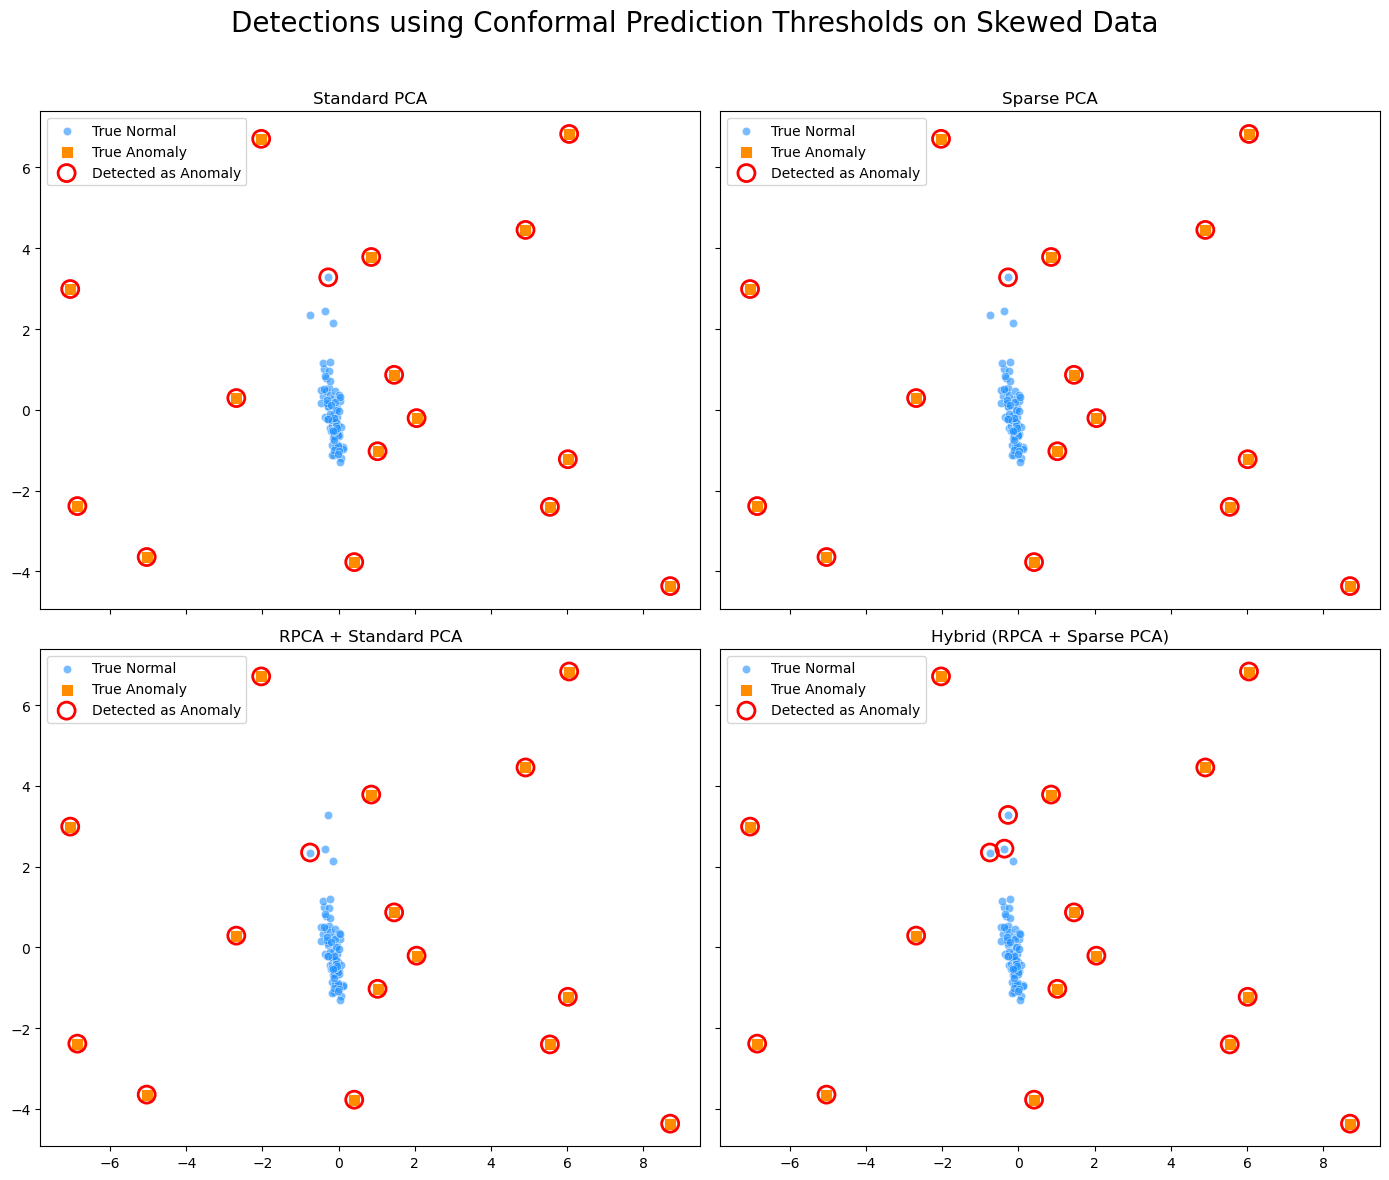

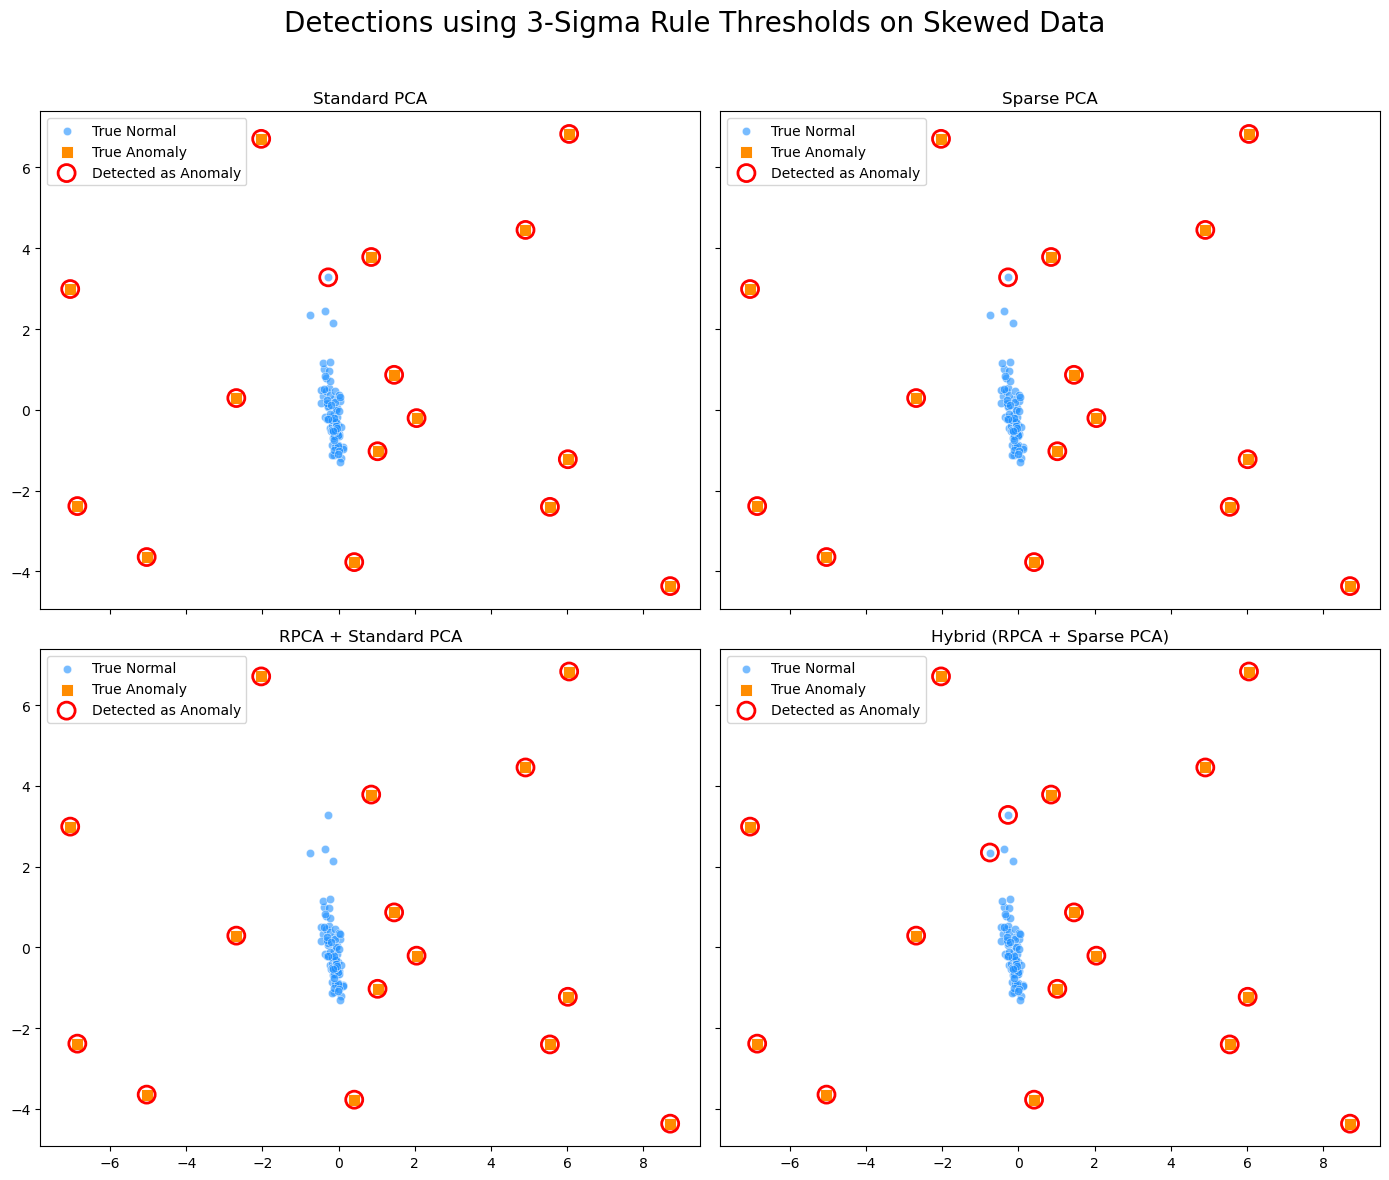

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# ==============================================================================
# RPCA Implementation (from GitHub: loiccoyle/RPCA)
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M; self.S = np.zeros(self.M.shape); self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda
    @staticmethod
    def _shrink(M, tau): return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))
    def fit(self, max_iter=1000, tol=1e-7):
        i = 0; err = np.inf; Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            k = min(self.M.shape) - 1
            if k <= 0: break
            from scipy.sparse.linalg import svds
            U, s, Vt = svds(self.M - self.S, k=k)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S

# --- 1. Data Generation (with Skewness) ---
np.random.seed(42)
n_features=10; n_informative_features=3
degrees_of_freedom = 4  # Lower df = more skew
true_weights=np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)

# Generate latent variables from a SKEWED distribution
latent_train = np.random.chisquare(degrees_of_freedom, (200, n_informative_features))
X_train_normal_true = latent_train @ true_weights + 0.1 * np.random.randn(200, n_features)
latent_cal = np.random.chisquare(degrees_of_freedom, (100, n_informative_features))
X_cal_normal = latent_cal @ true_weights + 0.1 * np.random.randn(100, n_features)
X_cv_pool_normal = np.vstack([X_train_normal_true, X_cal_normal])

# Test Data
n_test_samples=100; n_outliers_test=15
latent_test_normal = np.random.chisquare(degrees_of_freedom, (n_test_samples, n_informative_features))
X_test = latent_test_normal @ true_weights + 0.1 * np.random.randn(n_test_samples, n_features)
outlier_indices_test=np.random.choice(n_test_samples, n_outliers_test, replace=False)
X_test[outlier_indices_test] += 25 * (np.random.rand(n_outliers_test, n_features) - 0.5) # Increased magnitude for clarity
y_test_true = np.zeros(n_test_samples); y_test_true[outlier_indices_test]=1

# Contamination and Scaling
def contaminate(X, n_outliers_rate=0.1, magnitude=25):
    X_contaminated = X.copy()
    n_samples, n_features = X.shape; n_outliers = int(n_samples * n_outliers_rate)
    if n_outliers == 0: return X_contaminated
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    X_contaminated[outlier_indices] += magnitude * (np.random.rand(n_outliers, n_features) - 0.5)
    return X_contaminated

X_train_contaminated = contaminate(X_train_normal_true)
scaler = StandardScaler(); scaler.fit(X_train_contaminated)
X_cv_pool_scaled = scaler.transform(X_cv_pool_normal)
X_test_scaled = scaler.transform(X_test)

# --- 2. K-Fold Resampling, Threshold Comparison, and Evaluation ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
alpha = 0.05
quantile_level = 1 - alpha
all_predictions = {}
all_cal_scores = {} # To store scores for visualization

model_configs = {
    "Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": False},
    "Sparse PCA": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": False},
    "RPCA + Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": True},
    "Hybrid (RPCA + Sparse PCA)": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": True}
}

def get_reconstruction_errors(X, model):
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

for title, config in model_configs.items():
    print(f"--- Processing: {title} ---")
    all_predictions[title] = {}
    
    cal_scores_resampled = []
    for train_idx, cal_idx in kf.split(X_cv_pool_scaled):
        X_train_fold, X_cal_fold = X_cv_pool_scaled[train_idx], X_cv_pool_scaled[cal_idx]
        
        if config["use_rpca"]:
            X_train_fold_contaminated = contaminate(X_train_fold)
            decomposer = RPCADecomposition(X_train_fold_contaminated); L_matrix, _ = decomposer.fit()
            if L_matrix.shape[0] < n_informative_features: continue
            current_model = config["model"].fit(L_matrix)
        else:
            X_train_fold_contaminated = contaminate(X_train_fold)
            current_model = config["model"].fit(X_train_fold_contaminated)

        errors = get_reconstruction_errors(X_cal_fold, current_model)
        cal_scores_resampled.extend(errors)
    
    all_cal_scores[title] = cal_scores_resampled
    threshold_cp = np.quantile(cal_scores_resampled, quantile_level)
    threshold_3s = np.mean(cal_scores_resampled) + 3 * np.std(cal_scores_resampled)
    
    if config["use_rpca"]:
        decomposer = RPCADecomposition(scaler.transform(X_train_contaminated)); L_matrix, _ = decomposer.fit()
        final_model = config["model"].fit(L_matrix)
    else:
        final_model = config["model"].fit(scaler.transform(X_train_contaminated))

    test_scores = get_reconstruction_errors(X_test_scaled, final_model)
    all_predictions[title]["Conformal"] = (test_scores > threshold_cp).astype(int)
    all_predictions[title]["3-Sigma"] = (test_scores > threshold_3s).astype(int)

# --- 3. Print and Visualize All Results ---
print("\n\n" + "="*60 + "\n      FINAL PERFORMANCE: Conformal vs. 3-Sigma on SKEWED Data\n" + "="*60)
for model_name in model_configs.keys():
    print(f"\n--- {model_name} ---")
    print("--- (Threshold: Conformal Prediction) ---")
    print(classification_report(y_test_true, all_predictions[model_name]["Conformal"], target_names=['Normal', 'Anomaly'], zero_division=0))
    print("--- (Threshold: 3-Sigma Rule) ---")
    print(classification_report(y_test_true, all_predictions[model_name]["3-Sigma"], target_names=['Normal', 'Anomaly'], zero_division=0))

# Visualize the skewed error distribution for the best model
plt.figure(figsize=(10, 5))
sns.histplot(all_cal_scores["Hybrid (RPCA + Sparse PCA)"], bins=50, kde=True)
plt.title("Distribution of 'Normal' Reconstruction Errors (Note the Skewness)")
cp_threshold = np.quantile(all_cal_scores["Hybrid (RPCA + Sparse PCA)"], quantile_level)
s3_threshold = np.mean(all_cal_scores["Hybrid (RPCA + Sparse PCA)"]) + 3 * np.std(all_cal_scores["Hybrid (RPCA + Sparse PCA)"])
plt.axvline(cp_threshold, color='green', linestyle='--', linewidth=2, label=f'Conformal Threshold ({cp_threshold:.2f})')
plt.axvline(s3_threshold, color='red', linestyle='--', linewidth=2, label=f'3-Sigma Threshold ({s3_threshold:.2f})')
plt.legend()
plt.show()


# Visualize detection results
for method_name in ["Conformal", "3-Sigma"]:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    title_prefix = "Conformal Prediction" if method_name == "Conformal" else "3-Sigma Rule"
    fig.suptitle(f'Detections using {title_prefix} Thresholds on Skewed Data', fontsize=20)
    
    pca_vis = PCA(n_components=2)
    X_test_vis = pca_vis.fit_transform(X_test_scaled)
    
    for ax, (model_title, model_config) in zip(axes.flatten(), model_configs.items()):
        y_pred = all_predictions[model_title][method_name]
        sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
        sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
        detected_indices = np.where(y_pred == 1)[0]
        ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1],
                   s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
        ax.set_title(model_title)
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

---

## **The New Scenario: Multimodal "Normal" Data**

To create an even more challenging scenario that deviates further from normality, we will introduce multimodality into the "normal" data class.

This is a very common and difficult real-world problem where "normal" operation isn't a single state but can exist in several distinct modes (e.g., a machine operating at different load levels, or a system in "day" mode vs. "night" mode).

Instead of a single cloud of normal data, we will now generate "normal" points from **two separate, distinct clusters.**

**The Consequence:**

- A single, linear model like PCA is fundamentally unequipped to model this. It will attempt to find a single average basis that is a poor compromise between the two clusters.

- The reconstruction errors for these normal points will be complex and will certainly **not follow a Normal distribution**. The error distribution will likely be bimodal or very irregular.

- This scenario severely breaks the assumptions of the 3-Sigma rule. The "mean" of a bimodal distribution is often a meaningless value located in the empty space between the two peaks. Conformal Prediction, which is distribution-free, should handle this gracefully.

--- Processing: Standard PCA ---
--- Processing: Sparse PCA ---
--- Processing: RPCA + Standard PCA ---
--- Processing: Hybrid (RPCA + Sparse PCA) ---


      FINAL PERFORMANCE: Conformal vs. 3-Sigma on MULTIMODAL Data

--- Standard PCA ---
--- (Threshold: Conformal Prediction) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        85
     Anomaly       1.00      1.00      1.00        15

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

--- (Threshold: 3-Sigma Rule) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        85
     Anomaly       1.00      1.00      1.00        15

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


--- Sparse PCA ---
--- (Thre

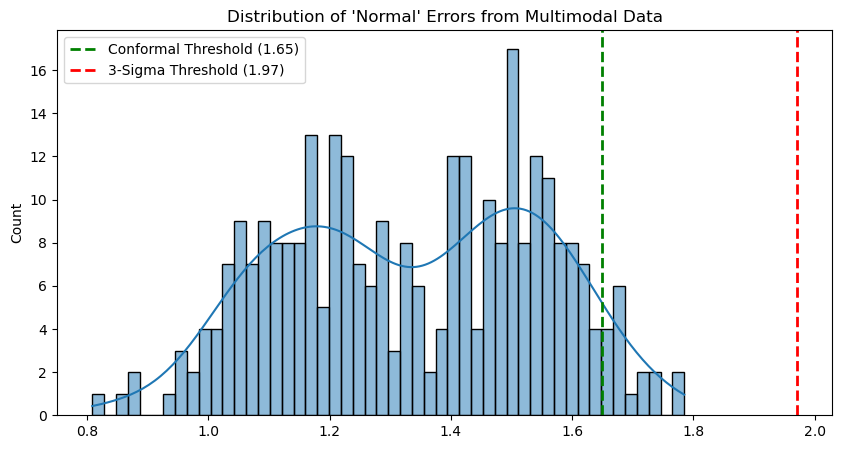

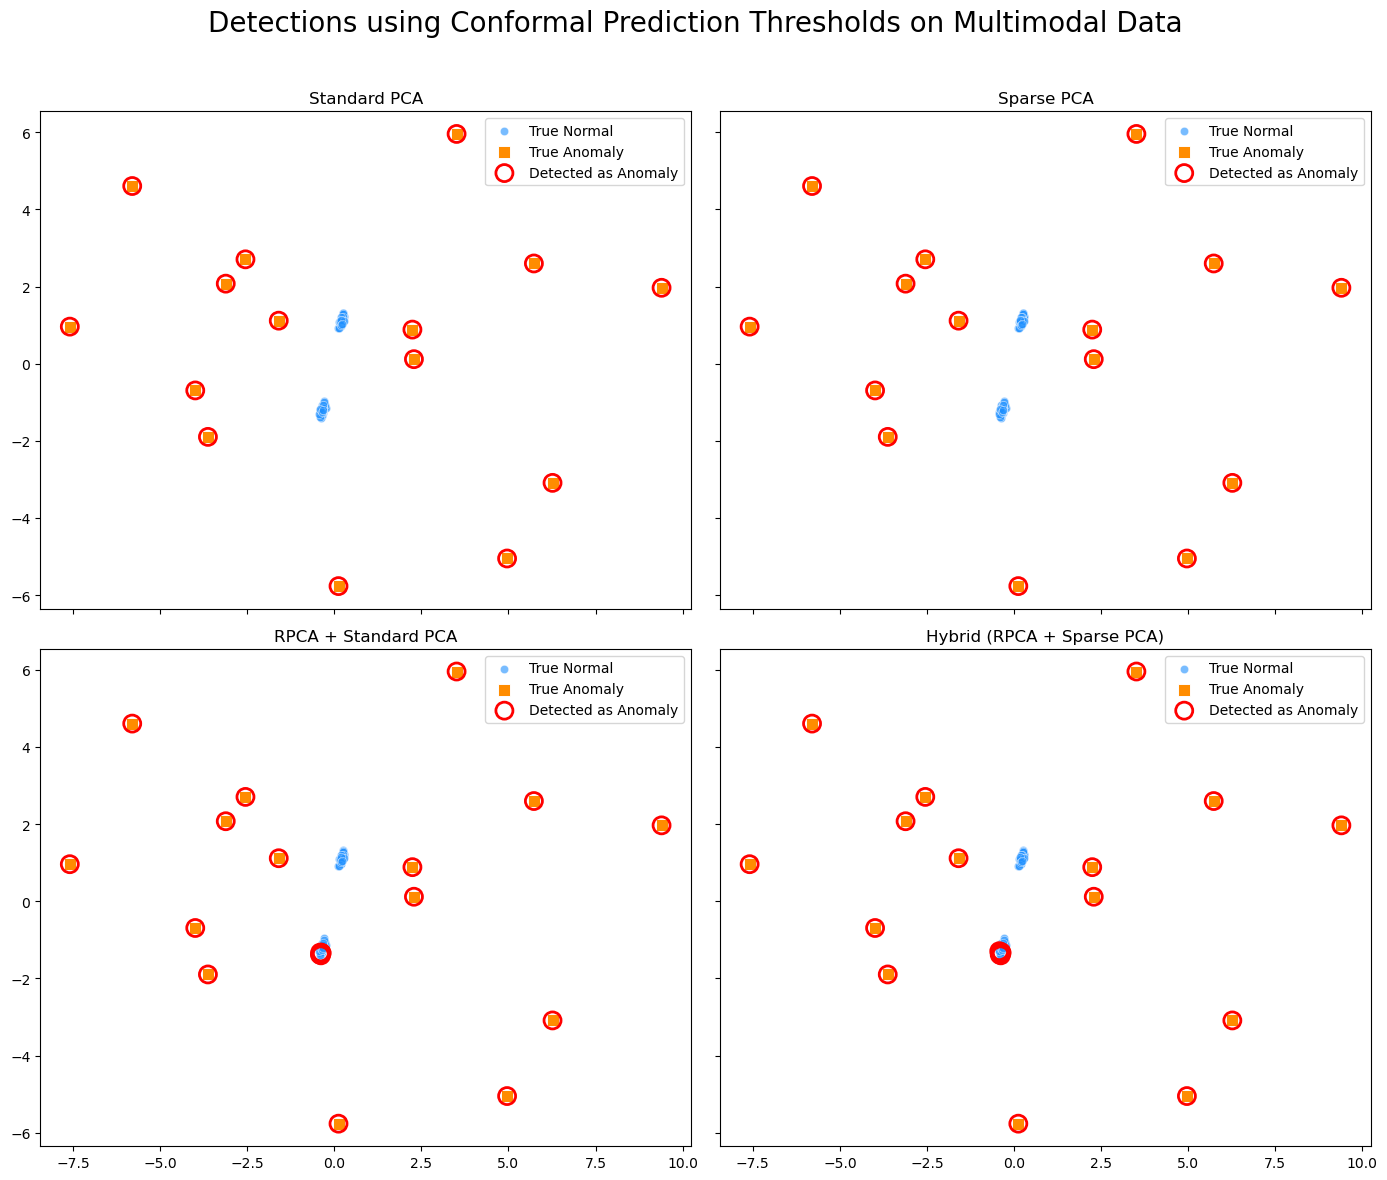

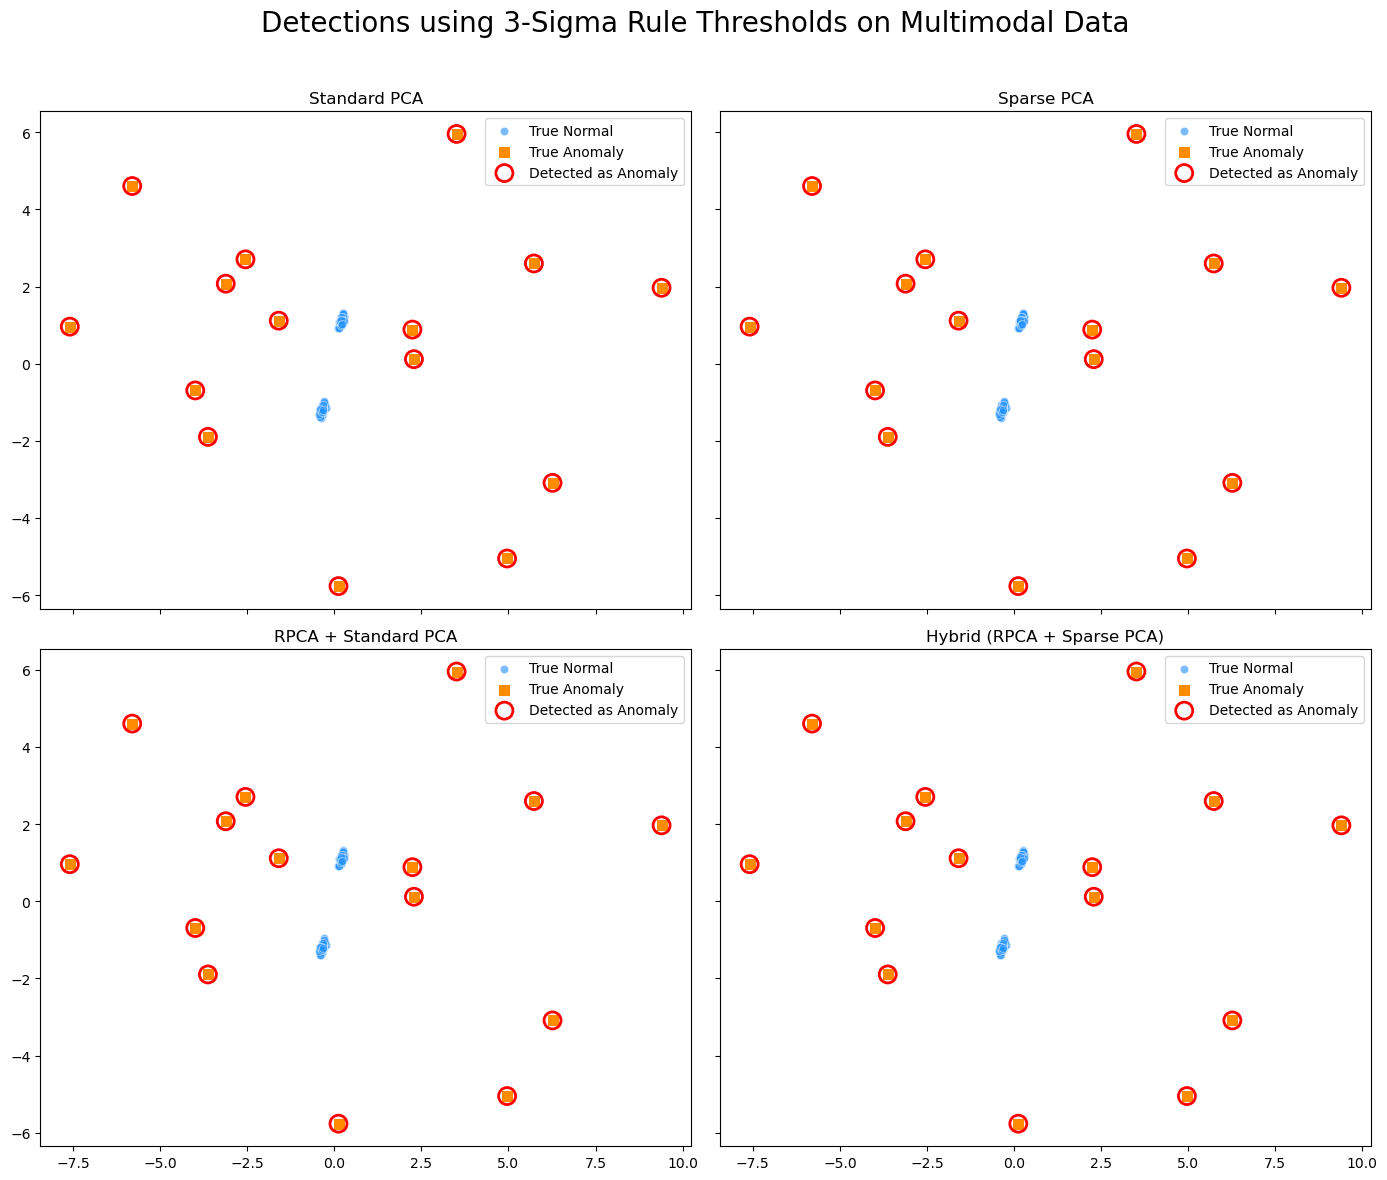

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# ==============================================================================
# RPCA Implementation (from GitHub: loiccoyle/RPCA)
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M; self.S = np.zeros(self.M.shape); self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda
    @staticmethod
    def _shrink(M, tau): return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))
    def fit(self, max_iter=1000, tol=1e-7):
        i = 0; err = np.inf; Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            k = min(self.M.shape) - 1
            if k <= 0: break
            from scipy.sparse.linalg import svds
            U, s, Vt = svds(self.M - self.S, k=k)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S

# --- 1. Data Generation (with MULTIMODALITY) ---
np.random.seed(42)
n_features=10; n_informative_features=3
true_weights=np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)

def generate_multimodal_normal_data(n_samples, n_features, n_informative_features, weights):
    """Generates normal data from two distinct clusters."""
    cluster_centers = [np.array([0]*n_informative_features), np.array([8]*n_informative_features)]
    
    # Assign each sample to a cluster
    cluster_assignments = np.random.randint(0, 2, n_samples)
    latent_vars = np.zeros((n_samples, n_informative_features))
    
    for i in range(n_samples):
        center = cluster_centers[cluster_assignments[i]]
        latent_vars[i] = center + np.random.randn(n_informative_features) * 0.5 # Tighter clusters
        
    return latent_vars @ weights + 0.1 * np.random.randn(n_samples, n_features)

# Generate datasets using the new multimodal function
X_train_normal_true = generate_multimodal_normal_data(200, n_features, n_informative_features, true_weights)
X_cal_normal = generate_multimodal_normal_data(100, n_features, n_informative_features, true_weights)
X_cv_pool_normal = np.vstack([X_train_normal_true, X_cal_normal])

# Test Data (normal part is also multimodal)
X_test_normal_part = generate_multimodal_normal_data(100, n_features, n_informative_features, true_weights)
n_outliers_test=15
outlier_indices_test=np.random.choice(100, n_outliers_test, replace=False)
X_test = X_test_normal_part
X_test[outlier_indices_test] += 40 * (np.random.rand(n_outliers_test, n_features) - 0.5) # Increased magnitude
y_test_true = np.zeros(100); y_test_true[outlier_indices_test]=1

# Contamination and Scaling
def contaminate(X, n_outliers_rate=0.1, magnitude=40):
    X_contaminated = X.copy()
    n_samples, n_features = X.shape; n_outliers = int(n_samples * n_outliers_rate)
    if n_outliers == 0: return X_contaminated
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    X_contaminated[outlier_indices] += magnitude * (np.random.rand(n_outliers, n_features) - 0.5)
    return X_contaminated

X_train_contaminated = contaminate(X_train_normal_true)
scaler = StandardScaler(); scaler.fit(X_train_contaminated)
X_cv_pool_scaled = scaler.transform(X_cv_pool_normal)
X_test_scaled = scaler.transform(X_test)


# --- 2. K-Fold Resampling, Threshold Comparison, and Evaluation (Code is IDENTICAL to previous step)---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
alpha = 0.05
quantile_level = 1 - alpha
all_predictions = {}
all_cal_scores = {}

model_configs = {
    "Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": False},
    "Sparse PCA": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": False},
    "RPCA + Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": True},
    "Hybrid (RPCA + Sparse PCA)": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": True}
}

def get_reconstruction_errors(X, model):
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

for title, config in model_configs.items():
    print(f"--- Processing: {title} ---")
    all_predictions[title] = {}
    
    cal_scores_resampled = []
    for train_idx, cal_idx in kf.split(X_cv_pool_scaled):
        X_train_fold, X_cal_fold = X_cv_pool_scaled[train_idx], X_cv_pool_scaled[cal_idx]
        
        if config["use_rpca"]:
            X_train_fold_contaminated = contaminate(X_train_fold)
            decomposer = RPCADecomposition(X_train_fold_contaminated); L_matrix, _ = decomposer.fit()
            if L_matrix.shape[0] < n_informative_features: continue
            current_model = config["model"].fit(L_matrix)
        else:
            X_train_fold_contaminated = contaminate(X_train_fold)
            current_model = config["model"].fit(X_train_fold_contaminated)

        errors = get_reconstruction_errors(X_cal_fold, current_model)
        cal_scores_resampled.extend(errors)
    
    all_cal_scores[title] = cal_scores_resampled
    threshold_cp = np.quantile(cal_scores_resampled, quantile_level)
    threshold_3s = np.mean(cal_scores_resampled) + 3 * np.std(cal_scores_resampled)
    
    if config["use_rpca"]:
        decomposer = RPCADecomposition(scaler.transform(X_train_contaminated)); L_matrix, _ = decomposer.fit()
        final_model = config["model"].fit(L_matrix)
    else:
        final_model = config["model"].fit(scaler.transform(X_train_contaminated))

    test_scores = get_reconstruction_errors(X_test_scaled, final_model)
    all_predictions[title]["Conformal"] = (test_scores > threshold_cp).astype(int)
    all_predictions[title]["3-Sigma"] = (test_scores > threshold_3s).astype(int)

# --- 3. Print and Visualize All Results ---
print("\n\n" + "="*60 + "\n      FINAL PERFORMANCE: Conformal vs. 3-Sigma on MULTIMODAL Data\n" + "="*60)
for model_name in model_configs.keys():
    print(f"\n--- {model_name} ---")
    print("--- (Threshold: Conformal Prediction) ---")
    print(classification_report(y_test_true, all_predictions[model_name]["Conformal"], target_names=['Normal', 'Anomaly'], zero_division=0))
    print("--- (Threshold: 3-Sigma Rule) ---")
    print(classification_report(y_test_true, all_predictions[model_name]["3-Sigma"], target_names=['Normal', 'Anomaly'], zero_division=0))

# Visualize the multimodal error distribution
plt.figure(figsize=(10, 5))
sns.histplot(all_cal_scores["Hybrid (RPCA + Sparse PCA)"], bins=50, kde=True)
plt.title("Distribution of 'Normal' Errors from Multimodal Data")
cp_threshold = np.quantile(all_cal_scores["Hybrid (RPCA + Sparse PCA)"], quantile_level)
s3_threshold = np.mean(all_cal_scores["Hybrid (RPCA + Sparse PCA)"]) + 3 * np.std(all_cal_scores["Hybrid (RPCA + Sparse PCA)"])
plt.axvline(cp_threshold, color='green', linestyle='--', linewidth=2, label=f'Conformal Threshold ({cp_threshold:.2f})')
plt.axvline(s3_threshold, color='red', linestyle='--', linewidth=2, label=f'3-Sigma Threshold ({s3_threshold:.2f})')
plt.legend()
plt.show()

# Visualize detection results
for method_name in ["Conformal", "3-Sigma"]:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    title_prefix = "Conformal Prediction" if method_name == "Conformal" else "3-Sigma Rule"
    fig.suptitle(f'Detections using {title_prefix} Thresholds on Multimodal Data', fontsize=20)
    
    pca_vis = PCA(n_components=2)
    X_test_vis = pca_vis.fit_transform(X_test_scaled)
    
    for ax, (model_title, model_config) in zip(axes.flatten(), model_configs.items()):
        y_pred = all_predictions[model_title][method_name]
        sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
        sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
        detected_indices = np.where(y_pred == 1)[0]
        ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1],
                   s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
        ax.set_title(model_title)
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

--- Processing: Standard PCA ---
Conformal Threshold calculated: 1.5478
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        85
     Anomaly       1.00      1.00      1.00        15

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

--- Processing: Sparse PCA ---
Conformal Threshold calculated: 1.6841
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        85
     Anomaly       1.00      1.00      1.00        15

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

--- Processing: RPCA + Standard PCA ---
Conformal Threshold calculated: 0.9493
              precision    recall  f1-score   support

      Normal       1.00      0.94      0.97        85
     Anomaly    

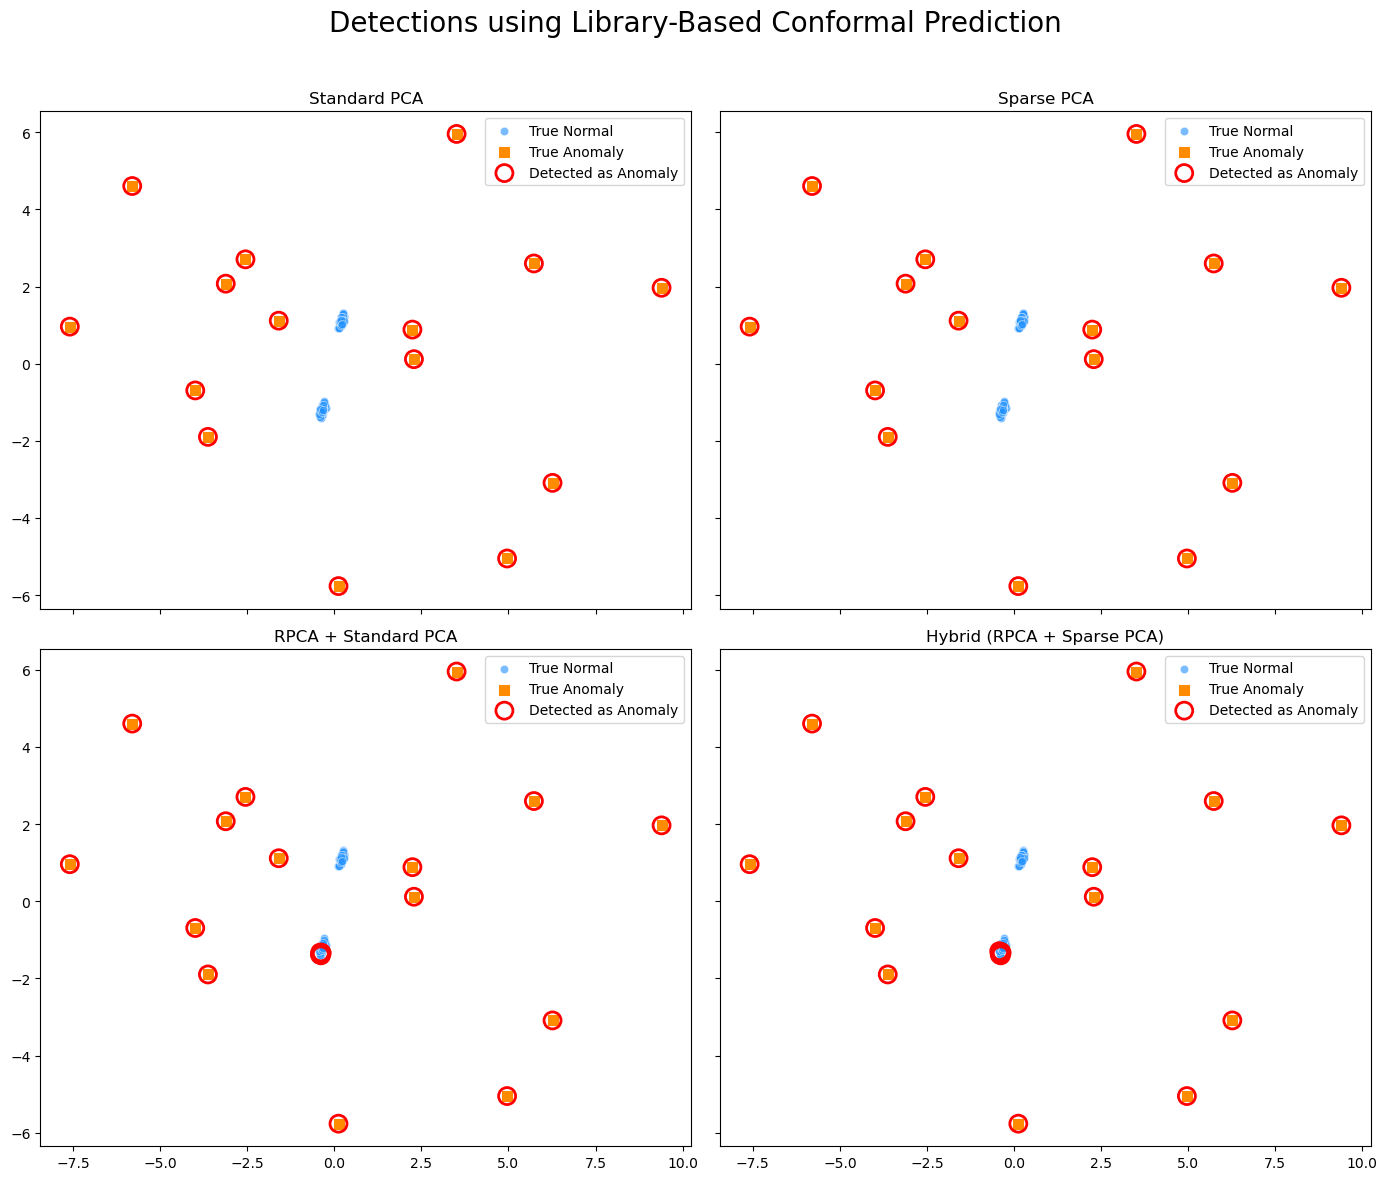

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.base import clone

# ==============================================================================
# RPCA Implementation (from GitHub: loiccoyle/RPCA)
# ==============================================================================
class RPCADecomposition:
    def __init__(self, M, lmbda=None):
        self.M = M; self.S = np.zeros(self.M.shape); self.L = np.zeros(self.M.shape)
        self.lmbda = 1/np.sqrt(np.max(self.M.shape)) if lmbda is None else lmbda
    @staticmethod
    def _shrink(M, tau): return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))
    def fit(self, max_iter=1000, tol=1e-7):
        i = 0; err = np.inf; Y = self.M
        while err > tol and i < max_iter:
            self.S = self._shrink(Y, self.lmbda)
            k = min(self.M.shape) - 1
            if k <= 0: break
            from scipy.sparse.linalg import svds
            U, s, Vt = svds(self.M - self.S, k=k)
            self.L = U @ np.diag(s) @ Vt
            Y = Y + self.M - self.L - self.S
            err = np.linalg.norm(self.M - self.L - self.S, 'fro') / np.linalg.norm(self.M, 'fro')
        return self.L, self.S

# --- 1. Data Generation (Multimodal) ---
np.random.seed(42)
n_features=10; n_informative_features=3
true_weights=np.random.randn(n_informative_features, n_features)
true_weights[:, n_informative_features:] = 0.05 * np.random.randn(n_informative_features, n_features - n_informative_features)

def generate_multimodal_normal_data(n_samples, n_features, n_informative_features, weights):
    cluster_centers = [np.array([0]*n_informative_features), np.array([8]*n_informative_features)]
    cluster_assignments = np.random.randint(0, 2, n_samples)
    latent_vars = np.zeros((n_samples, n_informative_features))
    for i in range(n_samples):
        center = cluster_centers[cluster_assignments[i]]
        latent_vars[i] = center + np.random.randn(n_informative_features) * 0.5
    return latent_vars @ weights + 0.1 * np.random.randn(n_samples, n_features)

X_train_normal_true = generate_multimodal_normal_data(200, n_features, n_informative_features, true_weights)
X_cal_normal = generate_multimodal_normal_data(100, n_features, n_informative_features, true_weights)
X_cv_pool_normal = np.vstack([X_train_normal_true, X_cal_normal])
X_test_normal_part = generate_multimodal_normal_data(100, n_features, n_informative_features, true_weights)
n_outliers_test=15
outlier_indices_test=np.random.choice(100, n_outliers_test, replace=False)
X_test = X_test_normal_part
X_test[outlier_indices_test] += 40 * (np.random.rand(n_outliers_test, n_features) - 0.5)
y_test_true = np.zeros(100); y_test_true[outlier_indices_test]=1

def contaminate(X, n_outliers_rate=0.1, magnitude=40):
    X_contaminated = X.copy()
    n_samples, n_features = X.shape; n_outliers = int(n_samples * n_outliers_rate)
    if n_outliers == 0: return X_contaminated
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    X_contaminated[outlier_indices] += magnitude * (np.random.rand(n_outliers, n_features) - 0.5)
    return X_contaminated

X_train_contaminated = contaminate(X_train_normal_true)
scaler = StandardScaler(); scaler.fit(X_train_contaminated)
X_cv_pool_scaled = scaler.transform(X_cv_pool_normal)
X_test_scaled = scaler.transform(X_test)

# --- 2. Conformal Prediction Implementation ---

def get_reconstruction_errors(X, model):
    return np.linalg.norm(X - model.inverse_transform(model.transform(X)), axis=1)

def get_conformal_threshold_with_cv(model_config, X_cv_pool, alpha, n_splits=5):
    """
    Calculates a robust anomaly threshold using K-Fold cross-validation.
    This is the core of the library-based Conformal Prediction pattern.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cal_scores = []
    
    for train_idx, cal_idx in kf.split(X_cv_pool):
        X_train_fold, X_cal_fold = X_cv_pool[train_idx], X_cv_pool[cal_idx]
        
        # Use a fresh clone of the model for each fold to prevent state leakage
        current_model = clone(model_config["model"])

        if model_config["use_rpca"]:
            X_train_fold_contaminated = contaminate(X_train_fold)
            decomposer = RPCADecomposition(X_train_fold_contaminated)
            L_matrix, _ = decomposer.fit()
            if L_matrix.shape[0] < model_config["model"].n_components: continue
            current_model.fit(L_matrix)
        else:
            X_train_fold_contaminated = contaminate(X_train_fold)
            current_model.fit(X_train_fold_contaminated)

        errors = get_reconstruction_errors(X_cal_fold, current_model)
        cal_scores.extend(errors)
    
    # Calculate the threshold from the distribution of out-of-sample scores
    return np.quantile(cal_scores, 1 - alpha)

# --- 3. Model Training, Calibration, and Evaluation ---

alpha = 0.05
all_predictions = {}
model_configs = {
    "Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": False},
    "Sparse PCA": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": False},
    "RPCA + Standard PCA": {"model": PCA(n_components=n_informative_features), "use_rpca": True},
    "Hybrid (RPCA + Sparse PCA)": {"model": SparsePCA(n_components=n_informative_features, random_state=42), "use_rpca": True}
}

for title, config in model_configs.items():
    print(f"--- Processing: {title} ---")
    
    # 1. Calibrate: Get robust threshold using the Conformal Prediction function
    threshold = get_conformal_threshold_with_cv(config, X_cv_pool_scaled, alpha=alpha)
    print(f"Conformal Threshold calculated: {threshold:.4f}")
    
    # 2. Train: Train the final model on the full training data
    final_model = clone(config["model"])
    if config["use_rpca"]:
        decomposer = RPCADecomposition(scaler.transform(X_train_contaminated))
        L_matrix, _ = decomposer.fit()
        final_model.fit(L_matrix)
    else:
        final_model.fit(scaler.transform(X_train_contaminated))
        
    # 3. Test: Evaluate on the test set using the calculated threshold
    test_scores = get_reconstruction_errors(X_test_scaled, final_model)
    y_pred = (test_scores > threshold).astype(int)
    all_predictions[title] = y_pred
    
    print(classification_report(y_test_true, y_pred, target_names=['Normal', 'Anomaly'], zero_division=0))

# --- 4. Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
fig.suptitle('Detections using Library-Based Conformal Prediction', fontsize=20)
pca_vis = PCA(n_components=2)
X_test_vis = pca_vis.fit_transform(X_test_scaled)

for ax, (title, y_pred) in zip(axes.flatten(), all_predictions.items()):
    sns.scatterplot(x=X_test_vis[y_test_true==0, 0], y=X_test_vis[y_test_true==0, 1], color='dodgerblue', alpha=0.6, label='True Normal', ax=ax)
    sns.scatterplot(x=X_test_vis[y_test_true==1, 0], y=X_test_vis[y_test_true==1, 1], color='darkorange', marker='s', s=70, label='True Anomaly', ax=ax)
    detected_indices = np.where(y_pred == 1)[0]
    ax.scatter(X_test_vis[detected_indices, 0], X_test_vis[detected_indices, 1],
               s=150, facecolors='none', edgecolors='red', linewidth=2, label='Detected as Anomaly')
    ax.set_title(title)
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()